# 1. Introduction

This notebook aims to explore the Rohlik orders data from the corresponding [Kaggle challenge](https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge). The challenge task was to forecast the "orders" column for the test data. In this notebook we will carry out exploratory data analysis to understand these data, with a focus on identifying patterns relevant to the number of orders attributed to the warehouses. We will then apply and compare different forecasting approaches, including more traditional methods (e.g., moving averages, ARIMA), global models (gradient-boosted trees) and neural networks (LSTMs). 

In [1]:
# Basic libraries
import os

# Data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

width, height = 9, 6

# Encoding and crossvalidation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.model_selection import TimeSeriesSplit

# Traditional methods
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ML / Global models

# # Remove warnings for notebook
# import warnings
# warnings.filterwarnings("ignore")

# 2. Basic data processing

In this section, we will have an initial look at the data and do some basic data processing, including:
 * Identifying missing data
 * Making datetime features
 * Joining tables

This section will not provide an in-depth explanation of the data, it is primarily focussed on basic processing steps, handling missing data and adding basic features, like "time to next holiday", "year" and "day of week". See section 2 for a more in-depth description of the data and exploratory analysis. This section will not deal with generating more advanced time series features (e.g., lags) or feature processing like one-hot encoding or scaling.

There are five files provided for this project (descriptions from kaggle):
 * **train.csv** - the training set containing the historical orders data and selected features described below
 * **test.csv** - the test set
 * **solution_example.csv** - a sample submission file in the correct format
 * **train_calendar.csv** - a calendar for the training set containing data about holidays or warehouse specific events, some columns are already in the train data but there are additional rows in this file for dates where some warehouses could be closed due to public holiday or Sunday (and therefore they are not in the train set)
 * **test_calendar.csv** - a calendar for the test set

In [2]:
if os.path.exists(os.path.join("/kaggle", "input")):
    data_dir = os.path.join("/kaggle", "input", "rohlik-orders-forecasting-challenge")
else:
    data_dir = os.path.join("rohlik-orders-forecasting-challenge")

# Load the CSV files into a dictionary
original_data = {}

for file_name in os.listdir(data_dir):

    original_data[file_name.replace(".csv", "")] = pd.read_csv(
        os.path.join(data_dir, file_name)
    )

    # Convert dates to datetime format
    if "date" in original_data[file_name.replace(".csv", "")].columns:

        original_data[file_name.replace(".csv", "")]["date"] = pd.to_datetime(
            original_data[file_name.replace(".csv", "")]["date"]
        )

        original_data[file_name.replace(".csv", "")] = original_data[
            file_name.replace(".csv", "")
        ].set_index("date")

Let's have a look at our data. The training set has information on holidays, warehouse shutdowns/blackouts, mov_change (change in minimum order value), weather and user activity on the website. More information is provided on these variables in section 2 of this notebook. We also get a `train_calendar` dataframe - much of the information from this is already in the training data, but there are additional rows in this file for dates when the warehouses are closed (i.e., due to public holidays or Sunday).

In [3]:
train, test = original_data["train"], original_data["test"]
train.head(5)

warehouse  orders holiday_name  holiday  shutdown  mini_shutdown  \
date                                                                          
2020-12-05  Prague_1  6895.0          NaN        0         0              0   
2020-12-06  Prague_1  6584.0          NaN        0         0              0   
2020-12-07  Prague_1  7030.0          NaN        0         0              0   
2020-12-08  Prague_1  6550.0          NaN        0         0              0   
2020-12-09  Prague_1  6910.0          NaN        0         0              0   

            shops_closed  winter_school_holidays  school_holidays  blackout  \
date                                                                          
2020-12-05             0                       0                0         0   
2020-12-06             0                       0                0         0   
2020-12-07             0                       0                0         0   
2020-12-08             0                       0                0         0   
2020-12-09             0                       0                0         0   

            mov_change  frankfurt_shutdown  precipitation  snow  \
date                                                              
2020-12-05         0.0                   0            0.0   0.0   
2020-12-06         0.0                   0            0.0   0.0   
2020-12-07         0.0                   0            0.0   0.0   
2020-12-08         0.0                   0            0.8   0.0   
2020-12-09         0.0                   0            0.5   0.0   

            user_activity_1  user_activity_2                   id  
date                                                               
2020-12-05           1722.0          32575.0  Prague_1_2020-12-05  
2020-12-06           1688.0          32507.0  Prague_1_2020-12-06  
2020-12-07           1696.0          32552.0  Prague_1_2020-12-07  
2020-12-08           1681.0          32423.0  Prague_1_2020-12-08  
2020-12-09           1704.0          32410.0  Prague_1_2020-12-09

## 2.1 Missing data

Below we see the ranges of the time series. All of them stop on `2024-03-15`, except for Budapest_1, because this was a holiday. Additionally, we see the differing start dates for the warehosues.

In [4]:
dates_df_train = (
    train.reset_index().groupby(["warehouse"])["date"].agg(["min", "max"]).reset_index()
)
dates_df_train.columns = ["warehouse", "start_date", "end_date"]
dates_df_train

warehouse start_date   end_date
0       Brno_1 2020-12-05 2024-03-15
1   Budapest_1 2020-12-05 2024-03-14
2  Frankfurt_1 2022-02-18 2024-03-15
3     Munich_1 2021-07-21 2024-03-15
4     Prague_1 2020-12-05 2024-03-15
5     Prague_2 2020-12-05 2024-03-15
6     Prague_3 2020-12-05 2024-03-15

The test set ranges from `2024-03-16` to `2024-05-15` for all warehouses.

In [5]:
dates_df_test = (
    test.reset_index().groupby(["warehouse"])["date"].agg(["min", "max"]).reset_index()
)
dates_df_test.columns = ["warehouse", "start_date", "end_date"]
dates_df_test

warehouse start_date   end_date
0       Brno_1 2024-03-16 2024-05-15
1   Budapest_1 2024-03-16 2024-05-15
2  Frankfurt_1 2024-03-16 2024-05-15
3     Munich_1 2024-03-16 2024-05-15
4     Prague_1 2024-03-16 2024-05-15
5     Prague_2 2024-03-16 2024-05-15
6     Prague_3 2024-03-16 2024-05-15

There are missing days in the train/test sets for some of the series, mostly due to lack of recording for Sundays. All of these instances are in the training and test calendars. For completeness, we will add rows for these dates, and simply leave the outcome and other missing variables as NA.

In [6]:
def add_missing_days(d, calendar, date_range, train_split=True):
    """
    Add the missing days in `d` while retaining holiday information (from `calendar`).

    Parameters:
        d (pd.DataFrame): Dataframe containing multiple time series (for each warehouse) with a DateTimeIndex. May not be complete (i.e., can be missing days)

        calendar (pd.DataFrame): DataFrame containing holiday information for each warehouse with a DateTimeIndex. Must be complete (i.e., no missing days)

        date_range (tuple): Tuple of two dates (strings formatted as 'YYYY-MM-DD') indicating the start and end date to be filled.

        train_split (bool): Whether or not this is the train data (vs. the test data).

    Returns:
        pd.DataFrame: Returns the input dataframe (`d`) with missing dates filled.
    """

    d = d.copy()
    calendar = calendar.copy()

    # Add missing columns
    calendar["id"] = (
        calendar["warehouse"]
        + "_"
        + calendar.index.year.astype(str)
        + "-"
        + calendar.index.month.astype(str)
        + "-"
        + calendar.index.day.astype(str)
    )

    calendar["user_activity_1"], calendar["user_activity_2"] = np.nan, np.nan
    if train_split:
        calendar["orders"] = np.nan

    # Indicate that the dates we are adding are closed days
    calendar["closed"] = 1
    d["closed"] = 0

    # Remove dates prior to opening
    calendar = calendar[
        (calendar.index >= date_range[0]) & (calendar.index <= date_range[1])
    ]

    if train_split:
        dates_df_train = (
            d.reset_index()
            .groupby(["warehouse"])["date"]
            .agg(["min", "max"])
            .reset_index()
        )
        dates_df_train.columns = ["warehouse", "start_date", "end_date"]

        for warehouse_name in dates_df_train["warehouse"]:
            calendar = calendar[
                ~(
                    (
                        calendar.index
                        < dates_df_train["start_date"][
                            dates_df_train["warehouse"] == warehouse_name
                        ].values[0]
                    )
                    & (calendar["warehouse"] == warehouse_name)
                )
            ]

    # Get date + warehouse index
    d = d.reset_index().set_index(["date", "warehouse"])
    calendar = calendar.reset_index().set_index(["date", "warehouse"])

    # Get the dates that aren't in the train/test sets
    calendar = calendar[~calendar.index.isin(d.index)]

    # Add these rows to the train/test sets
    d = pd.concat([d, calendar]).reset_index().set_index("date")

    return d


train = add_missing_days(
    train,
    original_data["train_calendar"].drop("warehouse_limited", axis=1),
    date_range=("2020-12-05", "2024-03-15"),
    train_split=True,
)

test = add_missing_days(
    test,
    original_data["test_calendar"],
    date_range=("2024-03-16", "2024-05-15"),
    train_split=False,
)

In [7]:
def missing_or_duplicate_dates(d):
    """
    Check for missing or duplicate dates

    Parameters:
        d (pd.DataFrame): Dataframe containing a time series with a DateTimeIndex

    Returns:
        bool: If True, there are missing or duplicate values in the series
    """

    full_range = pd.date_range(start=d.index.min(), end=d.index.max(), freq="D")
    missing_dates = full_range.difference(d.index)

    if len(missing_dates) > 0:
        print("Missing dates:", missing_dates)

    # Missing or duplicates
    return len(missing_dates) > 0 or d.index.duplicated().any()


# For each warehouse
for warehouse_name in train["warehouse"].unique():
    assert not missing_or_duplicate_dates(
        train[train["warehouse"] == warehouse_name].copy()
    )
    assert not missing_or_duplicate_dates(
        test[test["warehouse"] == warehouse_name].copy()
    )

It's worth noting that there are some features available in the training but not the test data. These are listed below.

We can group these into four categories:
 1. Shutdowns
 2. Change in minimum order value (mov_change)
 3. Weather
 4. User activity

In section 3 of this notebook we will consider whether these variables may have value for the prediction of sales. If so, it may be worth attempting to forecast these for the test data before attempting to predict order status. 

Now, let"s look at the number of NAs for each column. There are missing variables for the following columns:
 - `orders`, `user_activity`: We introduced these NAs when we filled in the missing dates. In reality, these days had 0 sales because they were closed. We will deal with these at the modelling stage - either by specifying that there were 0 orders or allowing the methods to deal with the NAs themselves.
 - `holiday_name`: These missings don"t match up with the holiday variable, though, as there are instances where `holiday == 1` but there is no holiday name, and cases where `holiday == 0` but there is a holiday name (i.e., minor "holidays" that aren"t associated with time off). We"ll fill in the missing holiday names with "none_or_unknown".
 - `precipitation`, `snow`: There are two issues here. First, there are a small number of seemingly random missing dates. Secondly, the weather data for Prague_3 is missing for a period. To deal with the small number of missing dates, we"ll use interpolation. To deal with the longer missing prague period, we will fill the Prague_3 data using the Prague_1 data, which is highly correlated (as shown by the plots below).

 Number of NAs by column:


In [8]:
# Get NAs
na_counts = train.isna().sum()
print(na_counts)

# Fill in holiday NAs
train.loc[train["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"
test.loc[test["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"

warehouse                    0
orders                     371
holiday_name              7377
holiday                      0
shutdown                     0
mini_shutdown                0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
blackout                     0
mov_change                   0
frankfurt_shutdown           0
precipitation              274
snow                       274
user_activity_1            371
user_activity_2            371
id                           0
closed                       0
dtype: int64


The plots below show the correlation of the Prague_3 warehouse vs. the other nearby warehouses. It seems the weather data is identical for Prague 1 and 2 but slightly different for Prague_3. The data are very similar though, so it seems reasonable to use the nearby precipitation data to fill the early Prague_3 values.

In the cells below, we:
 * Plot out the paired weather data for Prague 3 vs. Prague 1 and 2
 * Fill in the missing Prague 3 data using the Prague 1 data
 * Use forward interpolation to fill in the remaining missing values

We only have to worry about the training set, because we don't have weather data for the test set.

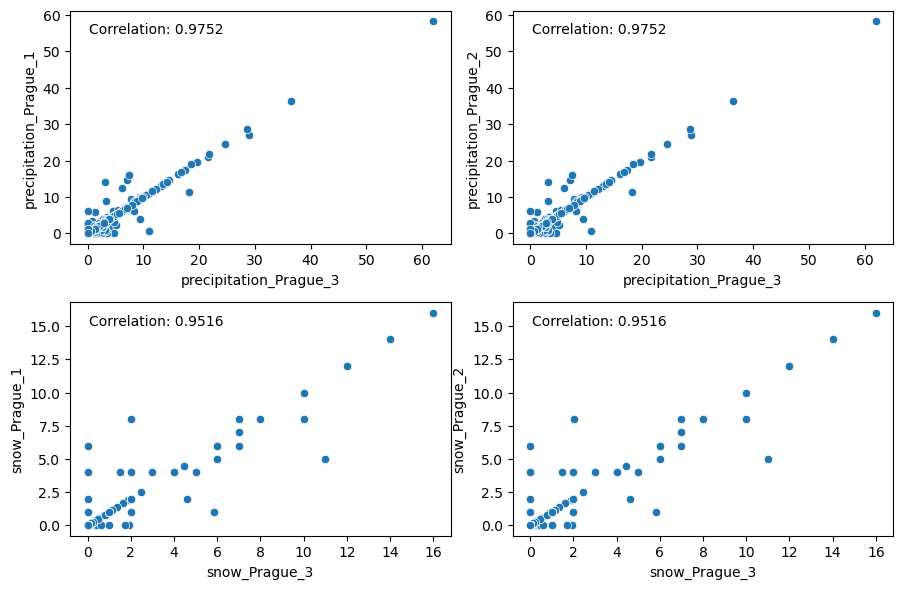

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(width, height))


def get_weather_paired(d, warehouse_pair, var_to_join):
    """
    Join the weather data from one warehouse onto another

    Parameters:
        d (pd.DataFrame): Dataframe containing a time series for each warehouse with a DateTimeIndex

        warehouse_pair (tuple): Length 2 tuple of strings referring to a pair of warehouses.

        var_to_join (str): The column name of the variable to be joined across the warehouses.

    Returns:
        pd.DataFrame: Returns the input dataframe with columns for each warehouse.
    """

    weather_paired = (
        d.loc[d["warehouse"] == warehouse_pair[0], var_to_join]
        .reset_index()
        .join(
            d.loc[d["warehouse"] == warehouse_pair[1], var_to_join]
            .reset_index()
            .set_index("date"),
            lsuffix=f"_{warehouse_pair[0]}",
            rsuffix=f"_{warehouse_pair[1]}",
            how="left",
            on="date",
        )
    )

    return weather_paired


# For each weather variable
for i, var_to_plot in enumerate(["precipitation", "snow"]):

    # Plot the comparisons of prague 3 to each of the other prague locations
    for j, warehouse_pair in enumerate(
        [["Prague_3", "Prague_1"], ["Prague_3", "Prague_2"]]
    ):
        weather_paired = get_weather_paired(train, warehouse_pair, var_to_plot)

        # Make plot for pair of warehouses
        sns.scatterplot(
            data=weather_paired,
            x=f"{var_to_plot}_{warehouse_pair[0]}",
            y=f"{var_to_plot}_{warehouse_pair[1]}",
            ax=ax[i, j],
        )

        # Report correlation
        correlation = weather_paired[f"{var_to_plot}_{warehouse_pair[0]}"].corr(
            weather_paired[f"{var_to_plot}_{warehouse_pair[1]}"]
        )

        ax[i, j].annotate(
            f"Correlation: {correlation:.4f}",
            xy=(0.05, 0.9),  # Coordinates in figure fraction (0 to 1)
            xycoords="axes fraction",  # Coordinate system of the plot
            fontsize=10,
        )

plt.tight_layout()
plt.show()

In [10]:
# For each weather variable
for i, var_to_join in enumerate(["precipitation", "snow"]):

    # Join the Prague 3 and Prague 1 weather values
    warehouse_pair = ["Prague_3", "Prague_1"]
    weather_paired = get_weather_paired(train, warehouse_pair, var_to_join)
    weather_paired = weather_paired.set_index("date")

    # Check the dates and NAs line up between the weather_paired and train dataframes
    assert (weather_paired.index == train.index[train["warehouse"] == "Prague_3"]).all()
    assert (
        train.loc[train["warehouse"] == "Prague_3", var_to_join].isna()
        == weather_paired[f"{var_to_join}_Prague_3"].isna()
    ).all()

    # Set the missing prague 3 values to the prague 1 values, then merge with the train set
    weather_paired.loc[
        weather_paired[f"{var_to_join}_Prague_3"].isna(), f"{var_to_join}_Prague_3"
    ] = weather_paired.loc[
        weather_paired[f"{var_to_join}_Prague_3"].isna(), f"{var_to_join}_Prague_1"
    ]

    train.loc[train["warehouse"] == "Prague_3", var_to_join] = weather_paired[
        f"{var_to_join}_Prague_3"
    ]

In [11]:
# Interpolate remaining precipitation values
for warehouse_name in train["warehouse"].unique():
    for var_to_interpolate in ["precipitation", "snow"]:
        train.loc[train["warehouse"] == warehouse_name, var_to_interpolate] = train.loc[
            train["warehouse"] == warehouse_name, var_to_interpolate
        ].interpolate(method="time", limit_direction="forward")

Finally, the only missing variables are for the `orders` and `user_activity` columns, and we know their true values for these days are in fact 0.

In [12]:
train.isna().sum()

warehouse                   0
orders                    371
holiday_name                0
holiday                     0
shutdown                    0
mini_shutdown               0
shops_closed                0
winter_school_holidays      0
school_holidays             0
blackout                    0
mov_change                  0
frankfurt_shutdown          0
precipitation               0
snow                        0
user_activity_1           371
user_activity_2           371
id                          0
closed                      0
dtype: int64

## 2.2 Basic feature creation and transformation

### 2.2.1 Date and holiday-related features

We add features for the year (years from study start), month, day of year, day of month and day of week.

In [13]:
def add_date_features(d):
    """
    Adds simple date features to the input DataFrame.

    Parameters:
        d (pd.DataFrame): A DataFrame containing a DateTimeIndex and a 'holiday_name' column.

    Returns:
        pd.DataFrame: Returns the input dataframe with additional columns.
    """

    # Years from dataset start rather than the actual year
    d["year"] = d.index.year - d.index.year.min()

    # Month and day of
    d["month"] = d.index.month
    d["dayofyear"] = d.index.dayofyear
    d["dayofmonth"] = d.index.day
    d["dayofweek"] = d.index.dayofweek

    # Lower case holiday names
    d["holiday_name"] = d["holiday_name"].str.lower()
    
    return d



train = add_date_features(train)

test = add_date_features(test)

There is an uptick of orders around the holidays. We add information about upcoming holidays to the calendars. These are known in advance, so we are not worried about data leakage.

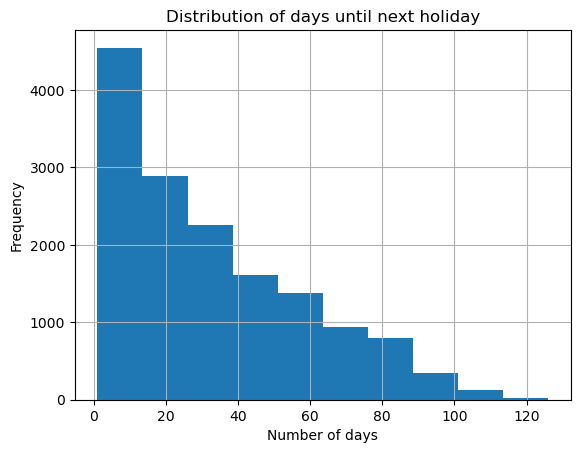

In [14]:
def get_holiday_name(calendar, date, warehouse_name):
    """
    Gets the holiday name for a given date/warehouse using a calendar

    Parameters:
        calendar (pd.DataFrame): Dataframe containing holiday information for each warehouse with a DateTimeIndex

        date (str): A string in 'YYYY-MM-DD' format indicating the date of the holiday

        warehouse_name (str): A string indicating the warehouse name

    Returns:
        str: The name of the holiday for the given date and warehouse.
    """

    holiday_name = calendar[
        (calendar.index == date) & (calendar["warehouse"] == warehouse_name)
    ]["holiday_name"]

    try:
        assert len(holiday_name) == 1

    except Exception as e:
        print(date)
        print("--")
        print(warehouse_name)
        print("--")
        print(holiday_name)
        raise e

    return holiday_name.iloc[0]


def get_next_holiday(calendar):
    """
    Takes a calendar and returns a new dataframe with the following additional columns:
     - "days_until_next_holiday"
     - "next_holiday_name"
     - "days_since_last_holiday"
     - "last_holiday_name"

     This is done on a per-warehouse basis
    """

    # Set up the sorted calendar with new columns
    calendar = calendar.copy()
    calendar = calendar.sort_index()
    calendar.loc[calendar["holiday_name"].isna(), "holiday_name"] = "none_or_unknown"
    calendar["days_until_next_holiday"], calendar["days_since_last_holiday"] = (
        np.nan,
        np.nan,
    )
    calendar["next_holiday_name"], calendar["last_holiday_name"] = None, None

    # For each day
    for i in range(len(calendar)):

        # Find the last and next holiday dates
        warehouse_name = calendar["warehouse"].iloc[i]
        warehouse_holidays = calendar.index[
            (calendar["holiday"] == 1) & (calendar["warehouse"] == warehouse_name)
        ]
        future_holidays = warehouse_holidays[warehouse_holidays > calendar.index[i]]
        past_holidays = warehouse_holidays[warehouse_holidays < calendar.index[i]]

        # Fill in future holidays up to this date
        if calendar.index[i] < pd.Timestamp("2024-10-31"):
            calendar.iloc[i, calendar.columns.get_loc("days_until_next_holiday")] = (
                future_holidays.min() - calendar.index[i]
            ).days
            calendar.iloc[i, calendar.columns.get_loc("next_holiday_name")] = (
                get_holiday_name(calendar, future_holidays.min(), warehouse_name)
            )

        # Fill in past holidays, except for first day of timeline (which we fill in manually)
        if calendar.index[i] == pd.Timestamp("2019-01-01"):
            calendar.iloc[i, calendar.columns.get_loc("days_since_last_holiday")] = 6
            calendar.iloc[i, calendar.columns.get_loc("last_holiday_name")] = (
                "2nd Christmas Day"
            )
        else:
            calendar.iloc[i, calendar.columns.get_loc("days_since_last_holiday")] = (
                calendar.index[i] - past_holidays.max()
            ).days
            calendar.iloc[i, calendar.columns.get_loc("last_holiday_name")] = (
                get_holiday_name(calendar, past_holidays.max(), warehouse_name)
            )

    return calendar[
        [
            "warehouse",
            "days_until_next_holiday",
            "next_holiday_name",
            "days_since_last_holiday",
            "last_holiday_name",
        ]
    ]


# Get next holiday data and join to the main datasets
next_holiday = get_next_holiday(
    pd.concat([original_data["train_calendar"], original_data["test_calendar"]])
)

# Plot out the distribution
next_holiday["days_until_next_holiday"].hist()
plt.title("Distribution of days until next holiday")
plt.xlabel("Number of days")
plt.ylabel("Frequency")
plt.show()

# Merge these data with the train and test sets
train = pd.merge(
    train.reset_index(),
    next_holiday.reset_index(),
    on=["date", "warehouse"],
    how="left",
).set_index("date")

test = pd.merge(
    test.reset_index(), next_holiday.reset_index(), on=["date", "warehouse"], how="left"
).set_index("date")

### 2.2.2 Miscellaneous features

In [15]:
# Feature for the warehouse region
train["region"], test["region"] = (
    train["warehouse"].str.split("_").str[0],
    test["warehouse"].str.split("_").str[0],
)

# Add mov_change to test set
test["mov_change"] = 0

# 3. Data exploration

In this section, we will attempt to understand our variables and perform exploratory analysis and visualisation.

The focal point of the dataset is the number of orders made over time for a set of warehouses. The orders are plotted over time for each warehouse below. The plot indicates frequent seasonal patterns and longer-term trends, which we will have to consider in our modelling process. We also see:
 * Extreme increases and decreases, which may correspond to holidays and shutdowns.
 * Similar patterns across the warehouses. Forecasting models may benefit from sharing information across warehouses.
 * Some warehouses were clearly opened later than others, given the large stretches of missing data.

Note that orders data is missing for days during which the warehouses were closed (i.e., during holidays, and for some warehouses Sundays). By default, we leave this data as missing in this section's plots. So, unless otherwise specified, when we plot out time series and distributions, we are looking at the data from the open days only.

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3301368867.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


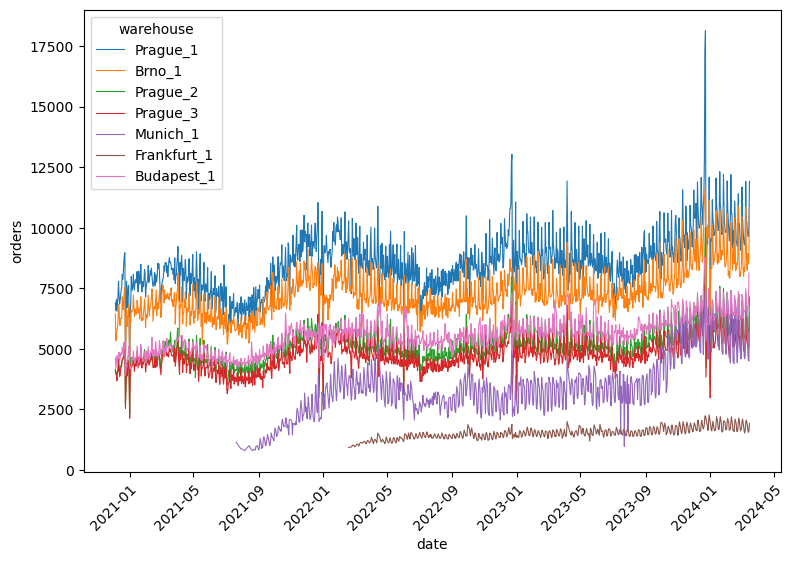

In [16]:
plt.figure(figsize=(width, height))
sns.lineplot(
    data=original_data["train"],
    x=original_data["train"].index,
    y=original_data["train"]["orders"],
    hue=original_data["train"]["warehouse"],
    errorbar=None,
    linewidth=0.8,
    palette="tab10",
)
ax = plt.gca()
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
plt.show()

## 3.1 Variable descriptions

In addition to orders, time and warehouse, we have access to a number of additional variables. Some of these were included in the original dataset ([see here](https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge/data)), others have been added or modified in the "Basic data processing" section above. We can group these as follows.

**Holiday information**

 * `holiday` / `winter_school_holidays` / `school_holidays` - Binary variables indicating presence of holidays.
 * `holiday_name` - The name of the holiday, if relevant.
 * `shops_closed` - Public holiday during which most shops are closed.
 * `days_until_next_holiday` / `next_holiday_name` / `days_since_last_holiday` / `last_holiday_name` - We added these variables in section 2 to indicate upcoming and previous holidays. Knowing that a holiday is upcoming may be relevant, as there could be an uptick of orders ahead of an event. Similarly, if a holiday has just ended, there could be a change in the number of orders.

**Date-derived variables**

 * `year`
 * `month`
 * `dayofyear`
 * `dayofmonth`
 * `dayofweek`

**Other**

 * `region` - We added this variable in section 2. E.g., warehouses "Prague_1" and "Prague_2" are in the same region. 


**Shutdown information** (not in test)

These are unexpected warehosue shutdowns (i.e., difficult to predict). We could either handle them by including them as predictors in our models, then setting their values to 0/False in the test set, or by ignoring them and hoping our models can learn to recognise and deal with shutdown events themselves. Given that we don't have this information in advance usually, the latter approach will probably lead to more generalisable models.

 * `shutdown`
 * `frankfurt_shutdown`
 * `mini_shutdown`
 * `blackout`
 
**Misc. non-categorical variables** (not in test)

These variables are also not present in the test set, but it may be more reasonable to include them in our models if possible. For instance, precipitation and snow are, to an extent, predictable in advance; we could include weather forecasts in our models. It could also be useful for us to build a model that predicts user activity, and feed this into our main order model. 

 * `mov_change` - A change in minimum order value.
 * `precipitation` - Precipitation in mm around the warehouse, which correlates with the location of the customers.
 * `snow` - Snowfall in mm. 
 * `user_activity_1` / `user_activity_2` - User activity on the website. Unclear from the dataset description what the difference is between the two variables, but they are quite different.

### 3.1.1 Variable distributions

Below, we see the distributions of our non-categorical variables. We can see that orders, being counts, has a slight positive skew. Counts data often has an overrepresentation of "0", but this isn't apparent in the histogram below. Note however, that the original dataset did not include the days where the warehouses were closed. Were we to set these days to "0", we would certainly see a larger number of 0-order days.

Minimum order value change is essentially a categorical variable that takes on values of 0, 0.7 and 1. 

Precipitation and snow have extreme positive distributions, with 0 values being greatly overrepresented. Were we to use these variables for prediction we would want to apply some transformation, either to reduce the skew or perhaps categorise days as "rainy", "snowy" or "dry". 

Finally, user activity has a kind of multi-modal distribution. Again, we don't see an inflation of 0s, but this is largely because we don't have data for these variables on the days the warehouses were closed.

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\547635904.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train[


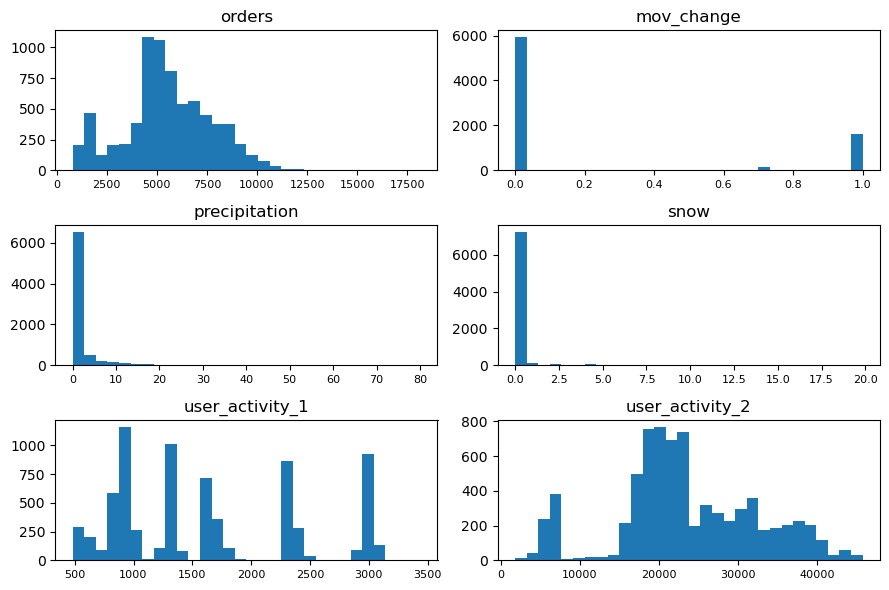

In [17]:
fig, ax = plt.subplots(figsize=(width, height))
train[
    [
        "orders",
        "mov_change",
        "precipitation",
        "snow",
        "user_activity_1",
        "user_activity_2",
    ]
].hist(xlabelsize=8, bins=30, grid=False, ax=ax)
plt.tight_layout()
plt.show()

Below, we show the orders by warehouse. For most of these, orders appear to follow a roughly normal distribution when we're not including the days during which the warehouses are closed. The forecasting task doesn't require us to predict the orders for closed days (we know they're 0), so it's up to us whether we want to exclude these days from the model, or include them after setting orders to 0.

<Figure size 900x600 with 0 Axes>

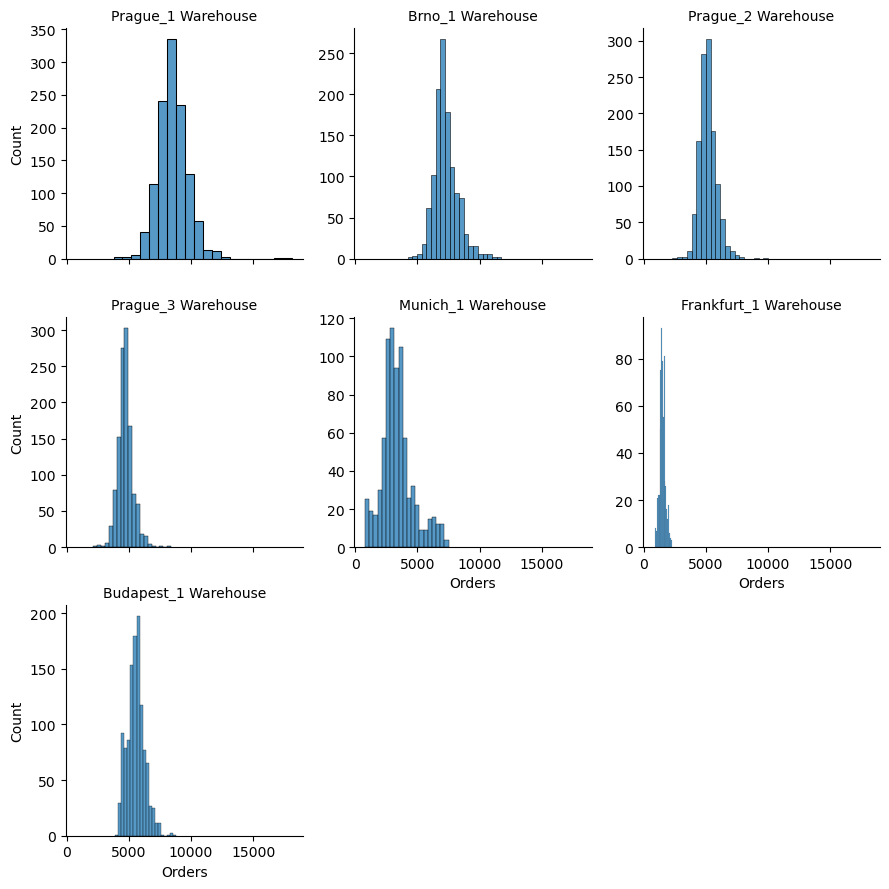

In [18]:
plt.figure(figsize=(width, height))
g = sns.FacetGrid(original_data["train"], col="warehouse", col_wrap=3, sharey=False)
g.map(sns.histplot, "orders", bins=20, kde=False)
g.set_axis_labels("Orders", "Count")
g.set_titles("{col_name} Warehouse")
plt.tight_layout()
plt.show()

### 3.1.2 Holiday names

Below, we see the number of each type of holiday in the training set (note that there is a calendar for each warehouse). There are a lot of different holiday names and it will be difficult for a model to take all of these into account. There are, however, similarities among the names (e.g., holidays with Christmas in the name, different types of memorials, Whit Monday and Sunday). Holidays with similar names might have similar effects on orders, so perhaps we can take this into account in our feature engineering process.

In [19]:
train["holiday_name"].value_counts()

holiday_name
none_or_unknown                                                7377
international womens day                                         26
2nd christmas day                                                25
christmas eve                                                    25
new years day                                                    25
1st christmas day                                                25
easter monday                                                    19
good friday                                                      19
labour day                                                       19
den osvobozeni                                                   12
jan hus                                                          12
cyrila a metodej                                                 12
den vzniku samostatneho ceskoslovenskeho statu                   12
den boje za svobodu a demokracii                                 12
den ceske statnosti                

### 3.1.3 Minimum order change

Minimum order change is usually zero, but there is a period of change from 2022-2023 that is similar across most of the warehosues.

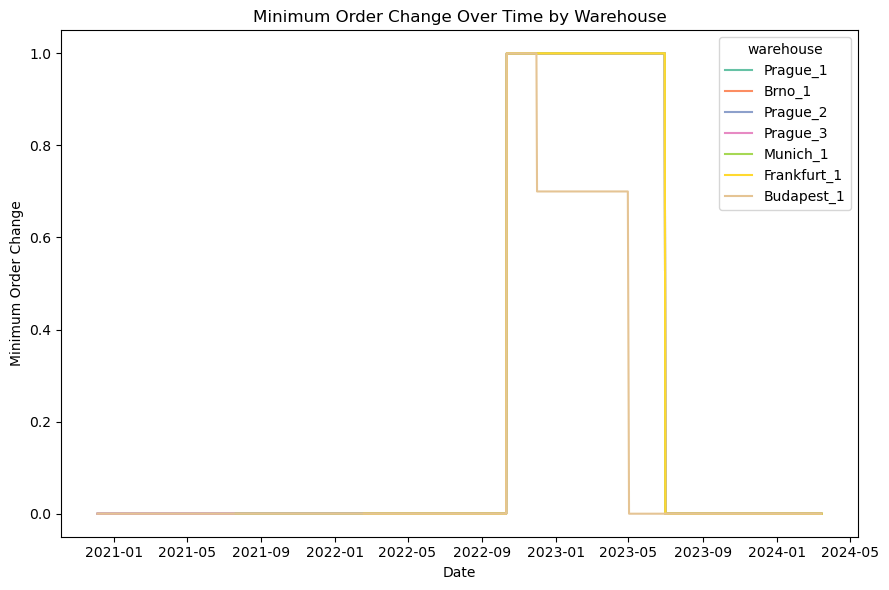

In [20]:
plt.figure(figsize=(width, height))
sns.lineplot(
    data=original_data["train"],
    x=original_data["train"].index,
    y="mov_change",
    hue="warehouse",
    palette="Set2",
)
plt.xlabel("Date")
plt.ylabel("Minimum Order Change")
plt.title("Minimum Order Change Over Time by Warehouse")
plt.tight_layout()
plt.show()

## 3.2 Simple variable comparisons

### 3.2.1 Comparing holiday variables

We have a few different variables for holiday types, which as we can see below have a lot of overlap. General holidays are distinct from winter and school holidays, which may still have an impact on orders. Shops are only closed on holidays, but not all holidays involve closing stores. So, there seems to be unique information captured by each of these columns.

In [21]:
columns_of_interest = ["winter_school_holidays", "school_holidays", "shops_closed"]

for col_name in columns_of_interest:
    crosstab = pd.crosstab(
        original_data["train_calendar"]["holiday"],
        original_data["train_calendar"][col_name],
    )
    print(f"Comparison of 'holiday' with '{col_name}':")
    print(crosstab)
    print("\n" + "-" * 50 + "\n")

Comparison of 'holiday' with 'winter_school_holidays':
winter_school_holidays      0    1
holiday                           
0                       12518  235
1                         544   10

--------------------------------------------------

Comparison of 'holiday' with 'school_holidays':
school_holidays      0   1
holiday                   
0                12692  61
1                  542  12

--------------------------------------------------

Comparison of 'holiday' with 'shops_closed':
shops_closed      0    1
holiday                 
0             12753    0
1               205  349

--------------------------------------------------



### 3.2.2 Correlation plots

We are interested in variables that explain our orders variable. Below, we attempt to do this with correlation to identify linear dependencies with other variables across the time course for each warehouse. This approach is not infalliable though, correlation will not necessarily pick up on non-linear associations and correlation may not be the best metric for rare categorical variables, like holidays. Furthermore, we have not detrended the series, so variables will show high correlation if they exhibit similar trend or cyclical patterns.

While we include some of the most relevant variables below, we don't include all of them. For instance:
 * Variables like `school_holidays`, `shutdown` and `closed` are highly correlated with orders, because they are only True when there are NA (i.e., 0) orders.
 * The `region` and `warehouse` variables are highly related to sales, but we are looking within warehouses.
 * Categorical variables like `holiday_name` may be relevant, but would be hard to correlate and plot clearly.

Some notable correlations include:
 * `orders` vs. `user_activity_1` vs. `user_activity_2` - User activity 2 has a strong correlation with orders across the warehouses. The first user activity also has correlations with orders from some warehouses, although this is not always positive. These variables are clearly providing different information, but this information differs based on the first vs. second activity variable.
 * `precipitation` / `snow` - Weak to non-existent correlations for most warehouses, although this may be an encoding issue (e.g., perhaps we could have tried these as binary variables). Because of these weak correlations and the fact these aren't in our test set, we will avoid moving forward with these variables.
 * `mov_change` - Displays some correlation across most warehouses. Indicates change in minimum order value, not present in the test set. Given its potential relevance, we can include this variable in the models by setting the value of it in the test set to 0. 
 * Holiday variables - Display some correlation with orders. While the overall correlation is modest, this variable is likely still relevant for predicting orders around holidays. In practice, prediction around and during holidays may be the most important period to forecast.
 * Days until next/last holiday - Shows low correlation, but again could be relevant to a small number of important timepoints.
 * `year` - Strong correlation indicating long-term trend.
 * Date variables - Except for year, these show modest to non-existent correlations. This may be because seasonal patterns (e.g. weekly) do not change linearly. 

As discussed, correlation is limited by its inability to consider non-linear relationships and it may not be the most appropriate metric for our rarer categorical variables. We will explore some of our variables in more detail later in the section.

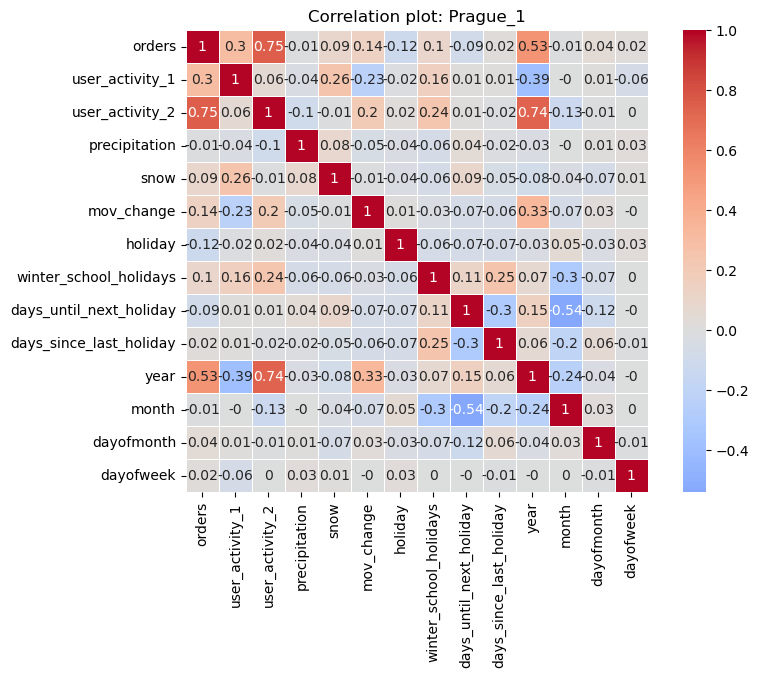

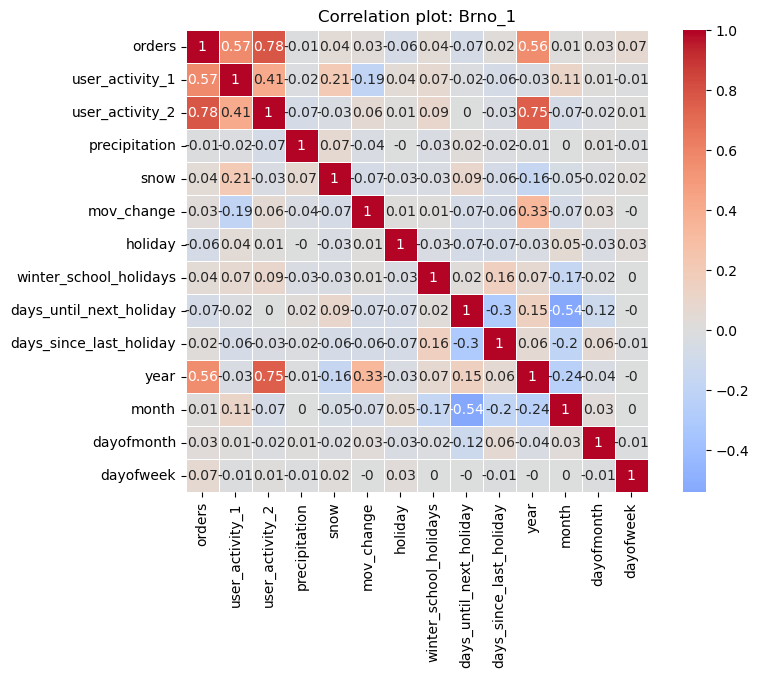

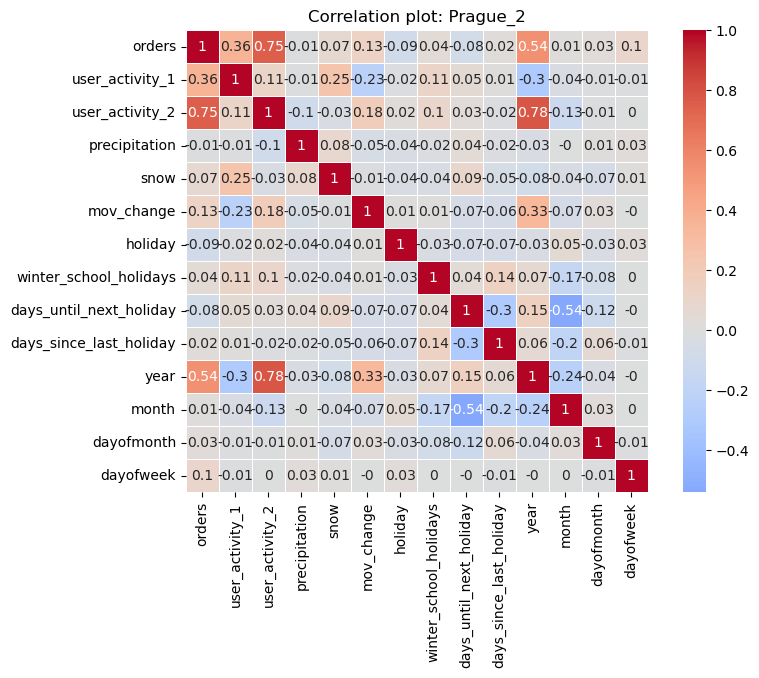

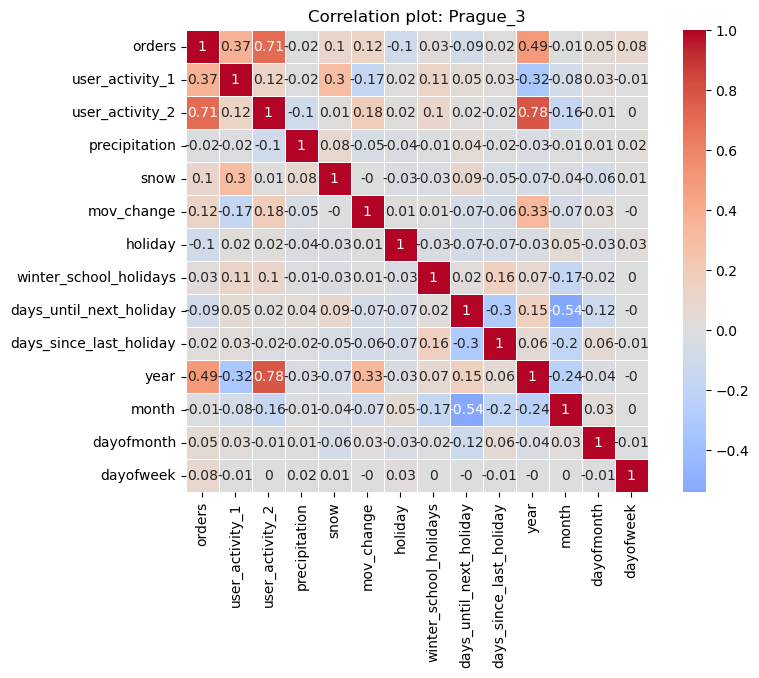

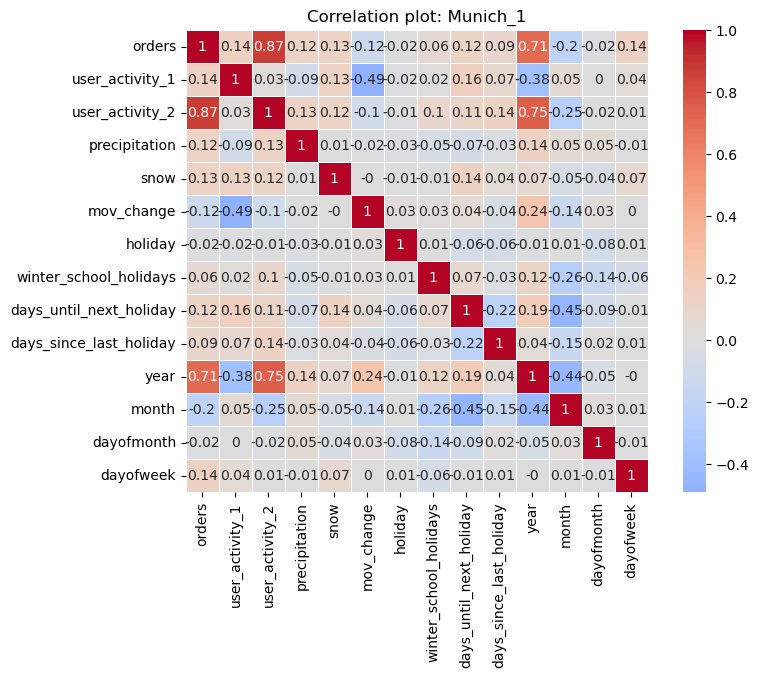

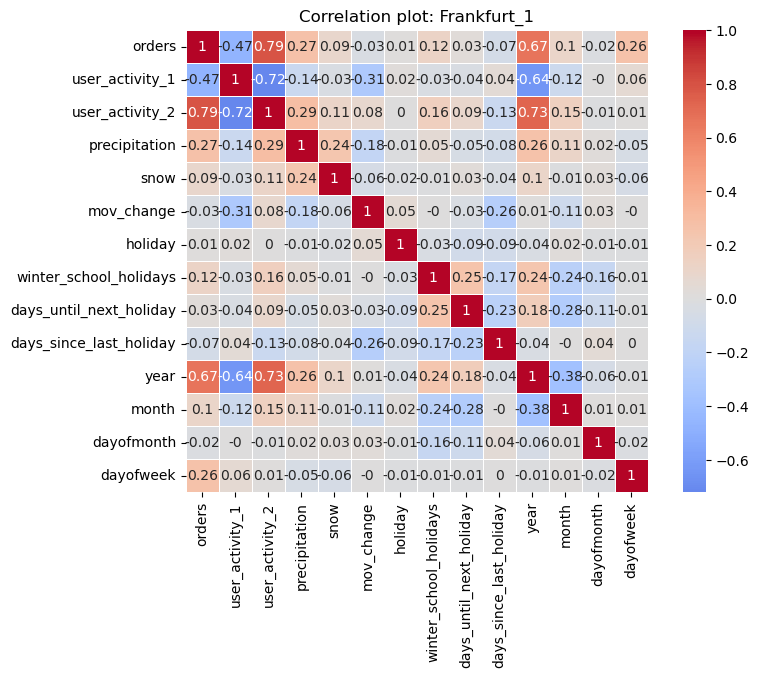

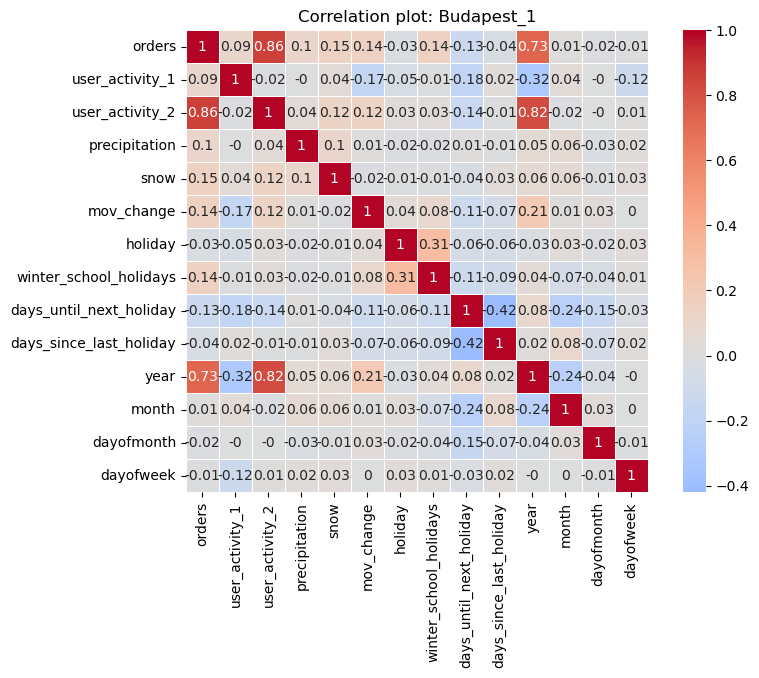

In [22]:
# The variables to be plotted in the correlation plot
vars_to_plot = [
    "orders",
    "user_activity_1",
    "user_activity_2",
    "precipitation",
    "snow",
    "mov_change",
    "holiday",
    "winter_school_holidays",
    "days_until_next_holiday",
    "days_since_last_holiday",
    "year",
    "month",
    "dayofmonth",
    "dayofweek",
]


def make_heatmap_from_df(d):
    """Make a correlation plot from a DataFrame"""
    correlation_matrix = d.corr().round(2)

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
    )


# Make the plot for each warehouse
for warehouse_name in train["warehouse"].unique():

    plt.figure(figsize=(width, height))
    make_heatmap_from_df(train[train["warehouse"] == warehouse_name][vars_to_plot])
    plt.title(f"Correlation plot: {warehouse_name}")
    plt.show()

### 3.2.3 Orders and user activity

We see that the user activity variables are highly dependent on the warehouse. Within a given warehouse, we see that `orders` seems to have limited dependence on `user_activity_1` but relatively strong dependence on `user_activity_2`.

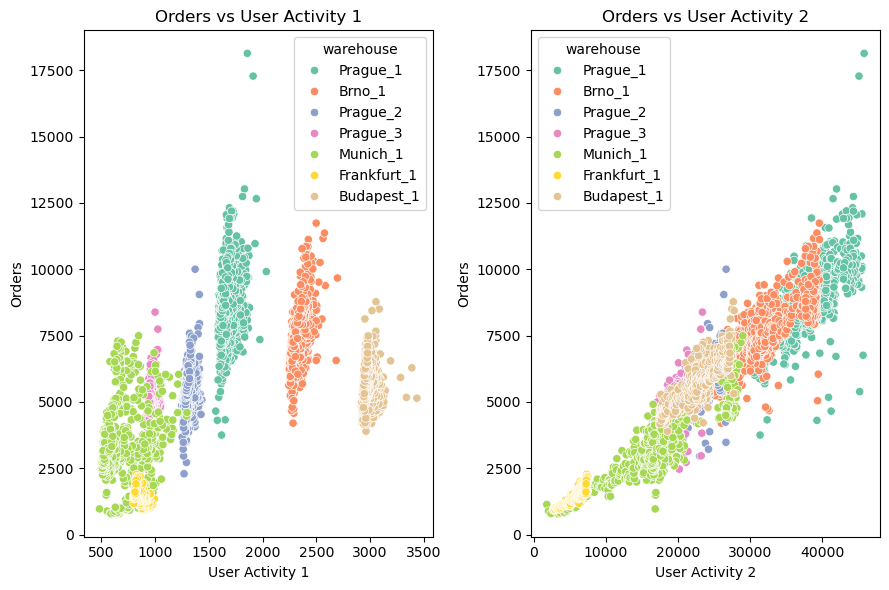

In [23]:
plt.figure(figsize=(width, height))

plt.subplot(1, 2, 1)
sns.scatterplot(
    data=train.reset_index(),
    x="user_activity_1",
    y="orders",
    hue="warehouse",
    palette="Set2",
)
plt.xlabel("User Activity 1")
plt.ylabel("Orders")
plt.title("Orders vs User Activity 1")

plt.subplot(1, 2, 2)
sns.scatterplot(
    data=train.reset_index(),
    x="user_activity_2",
    y="orders",
    hue="warehouse",
    palette="Set2",
)
plt.xlabel("User Activity 2")
plt.ylabel("Orders")
plt.title("Orders vs User Activity 2")

plt.tight_layout()
plt.show()

We can also see the correspondence of orders and user activity over time, below. The values of each series are each min-max scaled on a per-warehouse basis to help compare the series. 

We can see that increases or decreases in these variables very often correspond to changes in the total orders. 

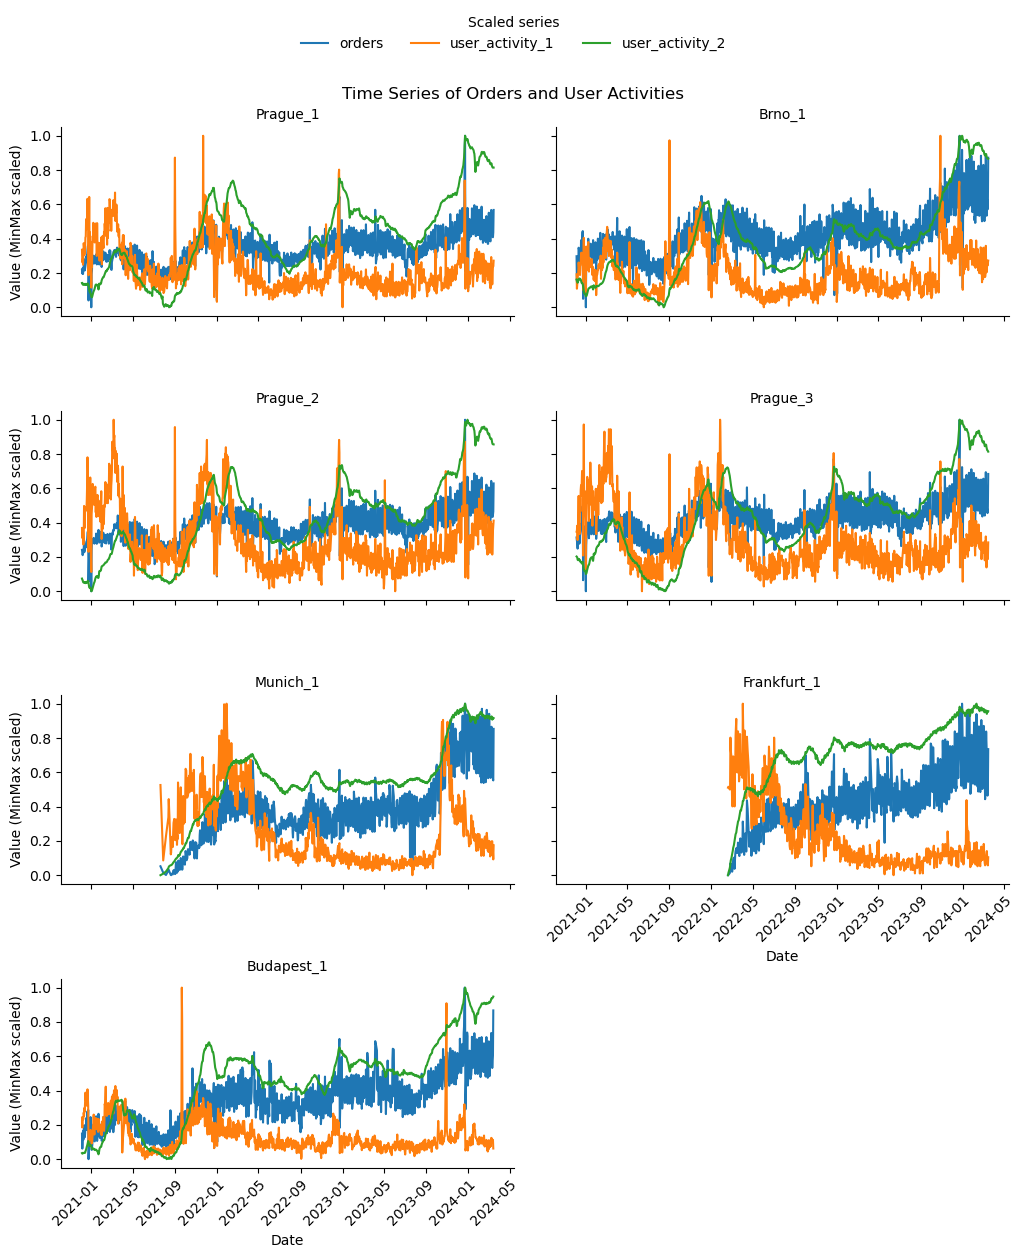

In [24]:
# Function for rotating labels
def rotate_labels(ax, angle=45):
    """Function for rotating labels"""
    for label in ax.get_xticklabels():
        label.set_rotation(angle)
        label.set_horizontalalignment("right")
        label.set_rotation_mode("anchor")
    return ax


# Set up scaler, values to plot and long-form data
mm_scaler = MinMaxScaler()

series_vars = ["orders", "user_activity_1", "user_activity_2"]

long_train = pd.melt(
    train.reset_index(),
    id_vars=["date", "warehouse"],
    value_vars=series_vars,
    var_name="variable",
    value_name="value",
)

# Scale values between 0 and 1.
for var_name in series_vars:
    for warehouse_name in long_train["warehouse"].unique():
        var_warehouse_rows = (long_train["variable"] == var_name) & (
            long_train["warehouse"] == warehouse_name
        )
        long_train.loc[var_warehouse_rows, "value"] = mm_scaler.fit_transform(
            long_train.loc[var_warehouse_rows, "value"].to_frame()
        )

# Create the faceted plot
g = sns.FacetGrid(long_train, col="warehouse", col_wrap=2, height=3, aspect=1)

g.map_dataframe(sns.lineplot, x="date", y="value", hue="variable")

# Adjust labels and titles
g.set_axis_labels("Date", "Value (MinMax scaled)")
g.set_titles(col_template="{col_name}")
g.add_legend(
    title="Scaled series", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3
)

for ax in g.axes.flatten():
    ax = rotate_labels(ax)

g.fig.suptitle("Time Series of Orders and User Activities")

plt.tight_layout()
plt.show()

## 3.3 Time series and decomposition

### 3.3.1 The impact of events on orders

In this section, we'll consider the impact of rarer events on the time series. First we'll look at the impact of `mov_change`, then we'll move on to consider the impact of holidays and closures on orders.

Below, we see the time series with a highlight for the period during which there is a change in minimum order value. In theory this could have an impact, but in practice it's not clear from the plots if this is the case. There was some correlation between `mov_change` and `orders` in the correlation plots, but this could just be capturing the general trend of the time series.

<Figure size 900x600 with 0 Axes>

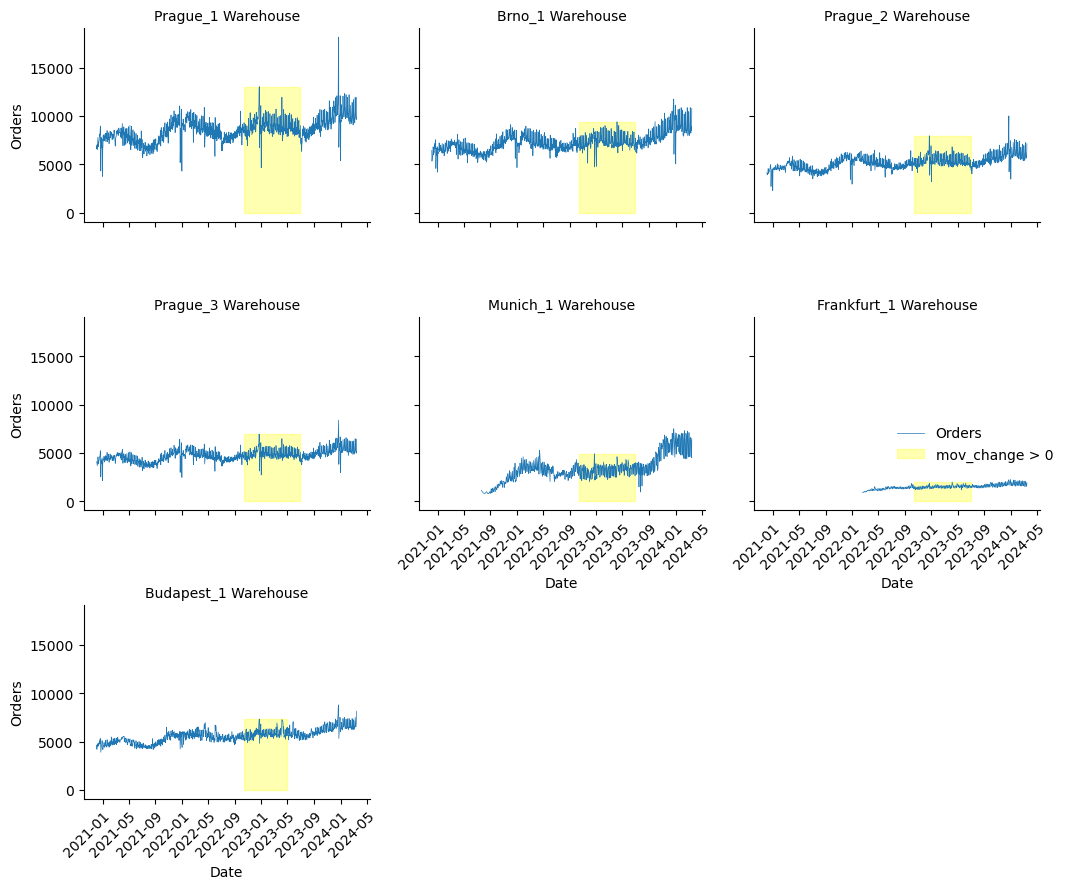

In [25]:
# Plot the orders
def plot_orders_with_highlight(data, **kwargs):
    """
    Plots the time series of orders vs. time with highlights for the mov_change variable.

    May be passed to Seaborn's map_dataframe function.

    Parameters:
        data (pd.DataFrame): Dataframe containing time series for each warehouse with a DateTimeIndex

        kwParameters: Additional arguments to be passed to Seaborn's lineplot function.

    Returns:
        None: Returns nothing, but creates plots given an axis.
    """
    # Plot the time series of orders
    sns.lineplot(
        data=data,
        x=data.index,
        y="orders",
        label="Orders",
        **kwargs,
        errorbar=None,
        linewidth=0.5
    )

    # Highlight the regions where mov_change > 0
    highlight = data[data["mov_change"] > 0]
    plt.fill_between(
        highlight.index,
        0,
        highlight["orders"].max(),
        color="yellow",
        alpha=0.3,
        label="mov_change > 0",
    )


# Make plot
fig = plt.figure(figsize=(width, height))
g = sns.FacetGrid(original_data["train"], col="warehouse", col_wrap=3)
g.map_dataframe(plot_orders_with_highlight)
g.set_axis_labels("Date", "Orders")
g.set_titles("{col_name} Warehouse")
g.add_legend()

# Rotate axes
for ax in g.axes.flatten():
    ax = rotate_labels(ax)

plt.tight_layout()
plt.show()

Below, we look at the distribution of orders by the `mov_change`, holiday and shutdown variables.. We show only the Brno_1 warehouse for simplicity. 

We see that shutdowns can have a big impact, but they are also very rare and they are difficult to predict in advance.

The median orders tends to decrease during a standard `holiday`, but it increases slightly during school holidays and it seems to increase quite significantly when shops are shut (although the variance of the orders also seems to increase during this time). These findings are generally consistent across the other warehouses (not shown).

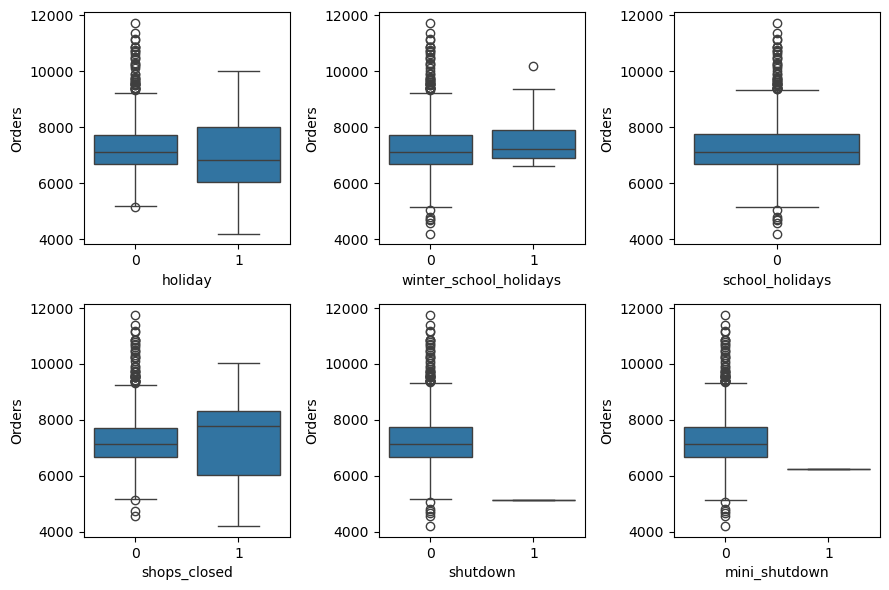

In [26]:
# Select specific columns of interest for an example warehouse
warehouse_name = "Brno_1"

columns_of_interest = [
    "holiday",
    "winter_school_holidays",
    "school_holidays",
    "shops_closed",
    "shutdown",
    "mini_shutdown",
    "blackout",
    "mov_change",
]

# Make a multi-panel figure with boxplots for orders stratified by the variables
fig, axes = plt.subplots(
    nrows=len(columns_of_interest) // 3, ncols=3, figsize=(width, height)
)
fig.tight_layout()

for ax, column in zip(axes.flatten(), columns_of_interest):
    sns.boxplot(
        data=train[train["warehouse"] == warehouse_name], x=column, y="orders", ax=ax
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Orders")

plt.tight_layout()
plt.show()

The holidays are split into standard `holiday`s, `winter_school_holidays` and `school_holidays`. But we can further split the `holiday`s by the `holiday_name` variable. It is likely that different types of holidays affect the orders very differently. Below, we plot the affect some of the most common holidays have on sales for each warehouse.

Some warehouses tend to be open on holidays, whereas for warehouses like Budapest, Munich and Frankfurt there are missing data for these days (indicating closures).

We can see that many of the holidays seem to increase or decrease the numbers of orders compared to the "none_or_unknown" category. Orders are down on Christmas eve and new years day, non-existent on christmas day and up on the "second christmas day" (i.e., people re-stocking or taking advantage of post-holiday offers?).

<Figure size 900x600 with 0 Axes>

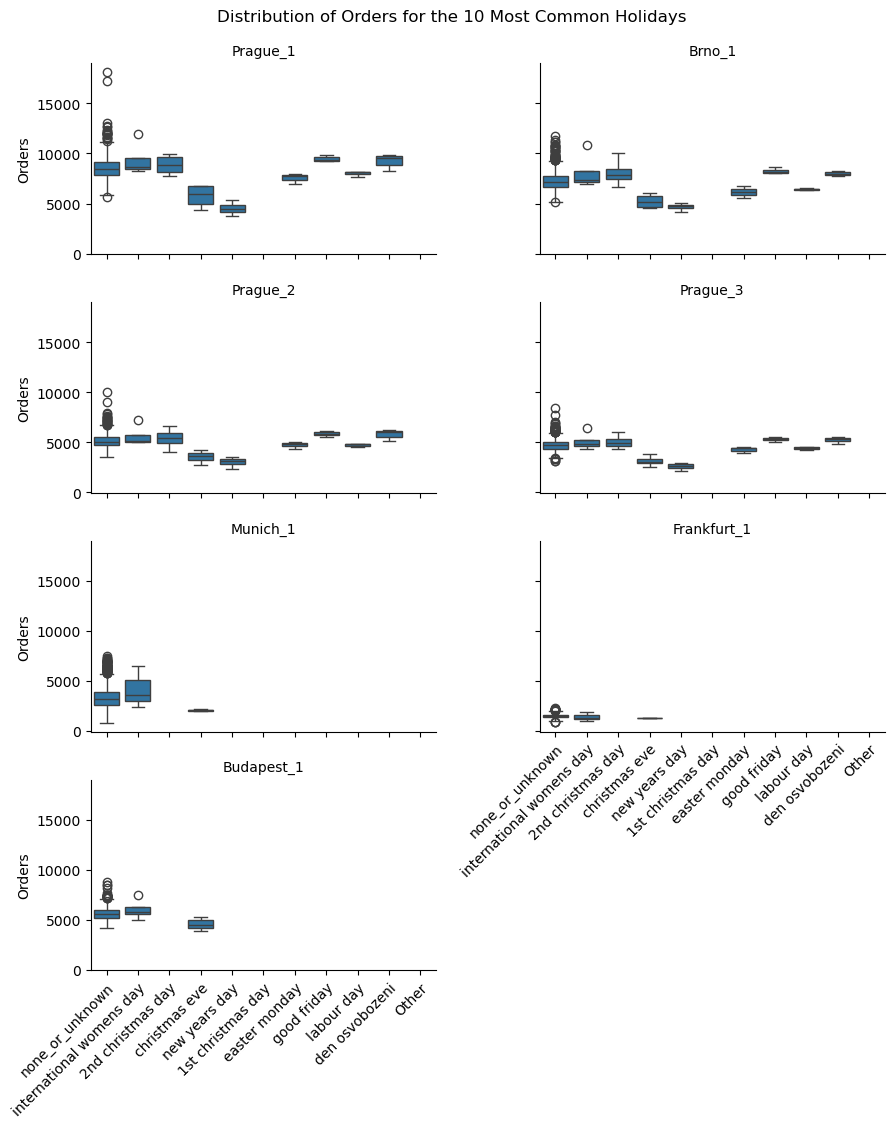

In [27]:
# 10 most common holidays (includes nameless holidays as a baseline)
top_holidays = train["holiday_name"].value_counts().nlargest(10).index

# Make boxplots for each warehouse
fig = plt.figure(figsize=(width, height))
g = sns.FacetGrid(
    train[train["holiday_name"].isin(top_holidays)],
    col="warehouse",
    col_wrap=2,
    height=2.5,
    aspect=1.8,
)

# Map the boxplot onto the grid
g.map_dataframe(
    sns.boxplot, x="holiday_name", y="orders", order=list(top_holidays) + ["Other"]
)
g.fig.subplots_adjust(hspace=0.25, wspace=0.3)

# Adjust labels and titles
g.set_axis_labels("", "Orders")
g.set_titles(col_template="{col_name}")
g.fig.suptitle(
    "Distribution of Orders for the 10 Most Common Holidays", y=1.02
)  # Title with margin adjustment

# Rotate x-axis labels
for ax in g.axes.flatten():
    ax = rotate_labels(ax)

plt.show()

Below, we plot out the time series for each warehouse, highlighting the following:

 * Holiday (red point)
 * Christmas holiday period (green shade)
 * School holiday period (yellow shade)
 * Winter school holiday period (blue shade)

We see that the holiday days and periods correspond to a lot of the peaks and troughs visible in the time series. However, we also see that these periods vary based on the region and year. So, it might be difficult for our models to learn a generalisable mapping of holidays to orders. 

Sometimes, we see a peak or trough just before or after a holiday or holiday period. In the previous data processing section, we created columns indicating the time to/from the next/previous holiday along with the type of holiday, which may allow the models to anticipate these.

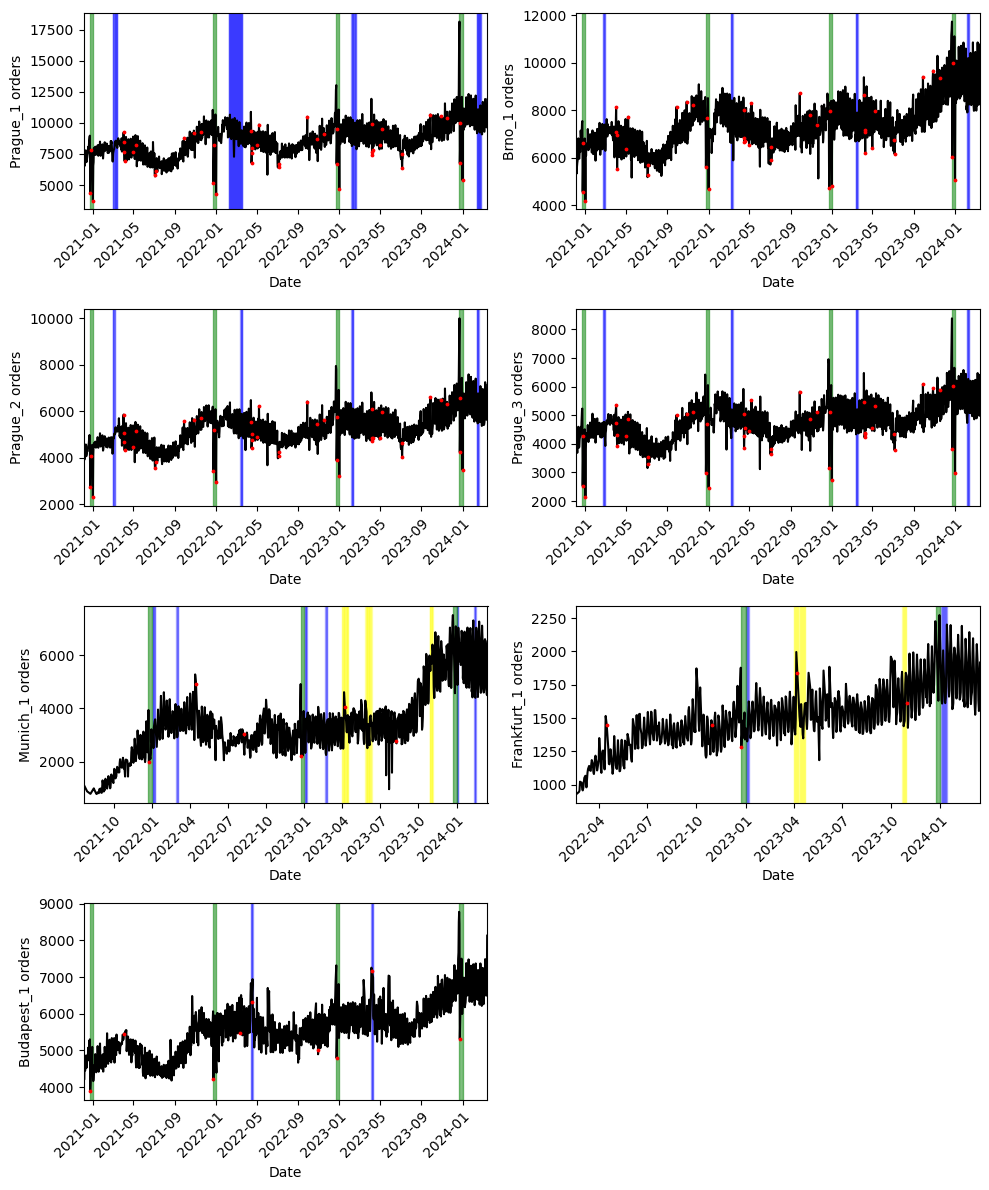

In [28]:
def shade_dates(ax, start_dates, end_dates, color, alpha=0.3, label=None):
    """Adds shading for a set of date ranges"""

    for start, end in zip(start_dates, end_dates):
        ax.axvspan(start, end, color=color, alpha=alpha, label=label)


# Make subplots, sharing axis is awkward so just show it for each
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(width + 1, 12))

# Loop through each warehouse
for ax, warehouse_name in zip(axes.flatten(), train["warehouse"].unique()):

    # Create the plot
    data = train[train["warehouse"] == warehouse_name]
    ax.plot(data.index, data["orders"], label="Orders", color="black")

    # Shade the school holidays
    school_holidays = data[data["school_holidays"] == 1]
    winter_school_holidays = data[data["winter_school_holidays"] == 1]

    shade_dates(
        ax,
        school_holidays.index,
        school_holidays.index,
        color="yellow",
        alpha=0.3,
        label="School Holidays",
    )

    shade_dates(
        ax,
        winter_school_holidays.index,
        winter_school_holidays.index,
        color="blue",
        alpha=0.3,
        label="Winter School Holidays",
    )

    # Shade the Christmas period
    shade_dates(
        ax,
        [
            pd.Timestamp(year=year, month=12, day=23)
            for year in data.index.year.unique()
        ],
        [
            pd.Timestamp(year=year + 1, month=1, day=1)
            for year in data.index.year.unique()
        ],
        color="green",
        alpha=0.5,
        label="Christmas Period",
    )

    # Highlight regular holidays with red points
    holidays = data[data["holiday"] == 1]
    ax.scatter(
        holidays.index, holidays["orders"], color="red", label="Holiday", zorder=5, s=3
    )

    # Add titles and labels
    ax.set_xlabel("Date")
    ax.set_ylabel(f"{warehouse_name} orders")
    ax.set_xlim(data.index.min(), data.index.max())
    ax = rotate_labels(ax)

fig.delaxes(axes.flatten()[7])
plt.tight_layout()
plt.show()

### 3.3.2 Exploring seasonality

#### 3.3.2.1 Periodograms

Periodograms can help indicate cyclical behaviour in time series data. Below, we plot one for each warehouse. These show strong weekly seasonalities for each warehouse. There's also generally a strong annual component. Some of the warehouses have a distinct semiweekly periodity according to the plots and there are some weak patterns for cycles occuring over a month to a year period for some warehouses. 

Note that we use a simple imputation (forward fill) to fill in NaN orders. This isn't too impactful for most warehouses, but some (like Frankfurt) are closed every Sunday. We could have set these orders to 0 (the true value) but including these 0 values creates an overwhelming cyclical effect that drowns out other interesting patterns.

Based on these plots, we likely want to take into account the weekly seasonality component using our forecasting models.

In [29]:
ax

<Axes: xlabel='Date', ylabel='Budapest_1 orders'>

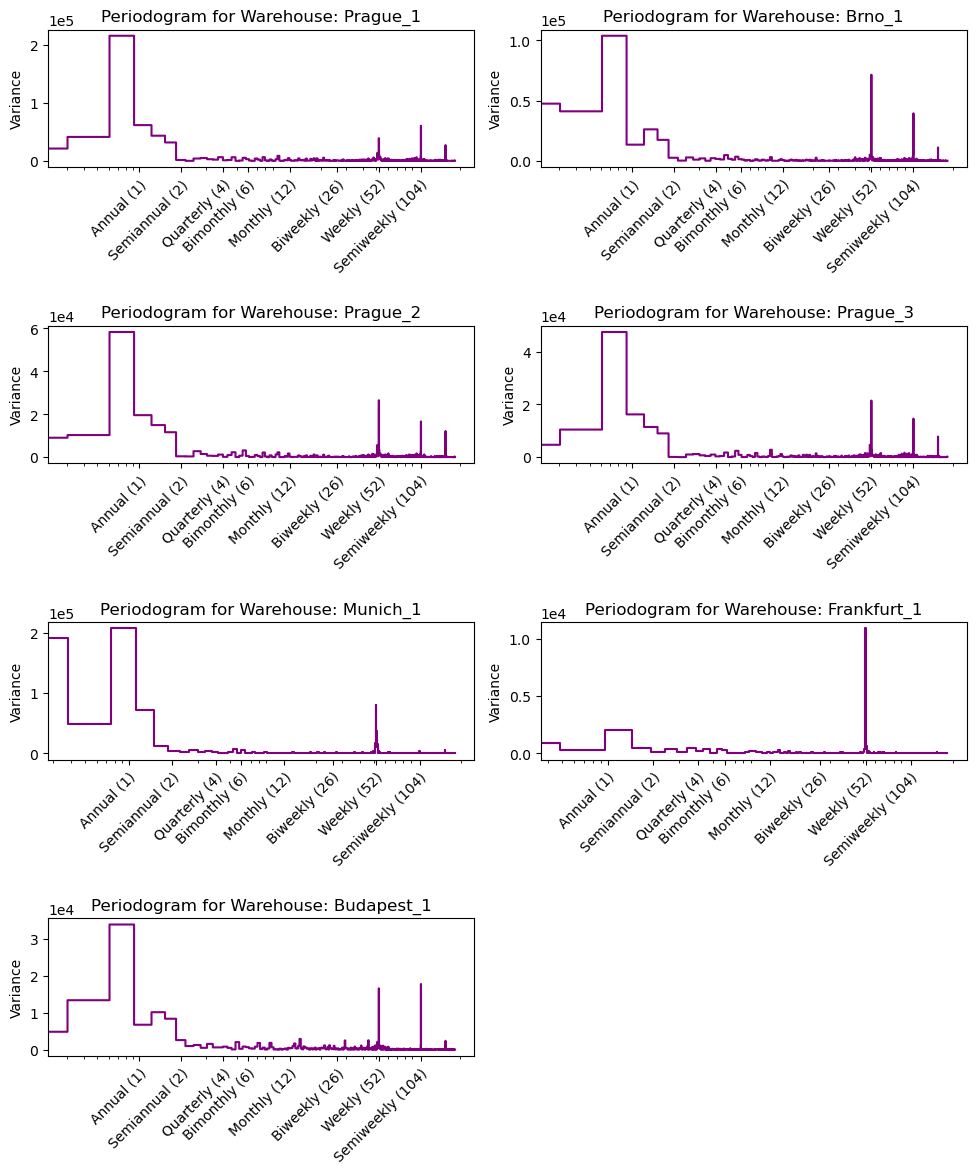

In [30]:
def plot_periodogram(ts, ax, detrend="linear"):
    """
    Plots a periodogram for a time series.

    Function based on: https://www.kaggle.com/code/yantxx/rohlik-forecasting-statistical-learning#1.2-Range-of-the-Time-Series

    Parameters:
        ts (pd.Series): The input time series containing a DateTimeIndex

        detrend (str): Detrend argument toe be passed to the `periodogram` function.

    Returns:
        matplotlib.axes.Axes: Returns the input axis.
    """

    # Create the periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")

    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )

    # Make the axis labels clearer (i.e., interpretable and readable frequency labels)
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ]
    )
    ax = rotate_labels(ax)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")

    return ax


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(width + 1, 12))

# Plot periodograms for each warehouse
for ax, warehouse_name in zip(axes.flatten(), train["warehouse"].unique()):

    data = train[train["warehouse"] == warehouse_name].copy().asfreq("D")
    orders = data["orders"].ffill()

    plot_periodogram(orders, ax=ax)
    ax.set_title(f"Periodogram for Warehouse: {warehouse_name}")

fig.delaxes(axes.flatten()[7])
plt.tight_layout()
plt.show()

#### 3.3.2.2 Seasonal visualisations

Below, we plot the distribution of the orders for each warehouse. There tends to be an uptick in orders towards the end of the week (i.e., Friday/Saturday) and there's often a fall in orders on Sunday.

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2769761798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2769761798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2769761798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2769761798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

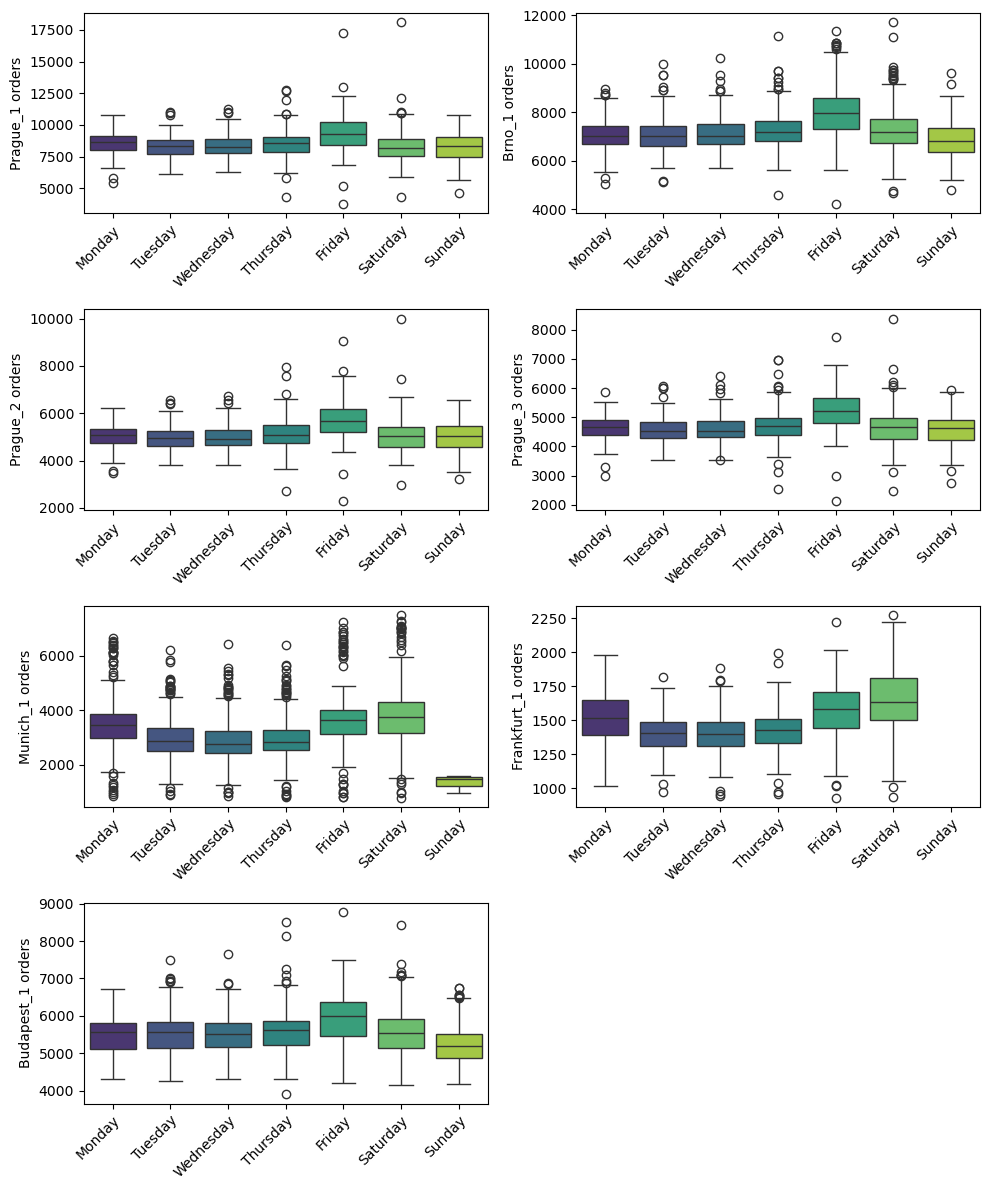

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(width + 1, 12))

# Plot weekly boxplots for each warehouse
for ax, warehouse_name in zip(axes.flatten(), train["warehouse"].unique()):

    sns.boxplot(
        x="dayofweek",
        y="orders",
        data=train[train["warehouse"] == warehouse_name],
        palette="viridis",
        ax=ax,
    )

    # Set labels and title
    ax.set_xlabel("")
    ax.set_ylabel(f"{warehouse_name} orders")
    ax.set_xticks(
        ticks=range(7),
        labels=[
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ],
    )
    ax = rotate_labels(ax)

fig.delaxes(axes.flatten()[7])
plt.tight_layout()
plt.show()

Next, we investigate the yearly seasonality that was evident in the periodograms. We overlay the orders across multiple years for each warehouse.

We see fairly similar annual patterns across the warehouses, with orders falling from the start of the year, a depression in the middle of the year, and an increase towards Christmas/New Year. 

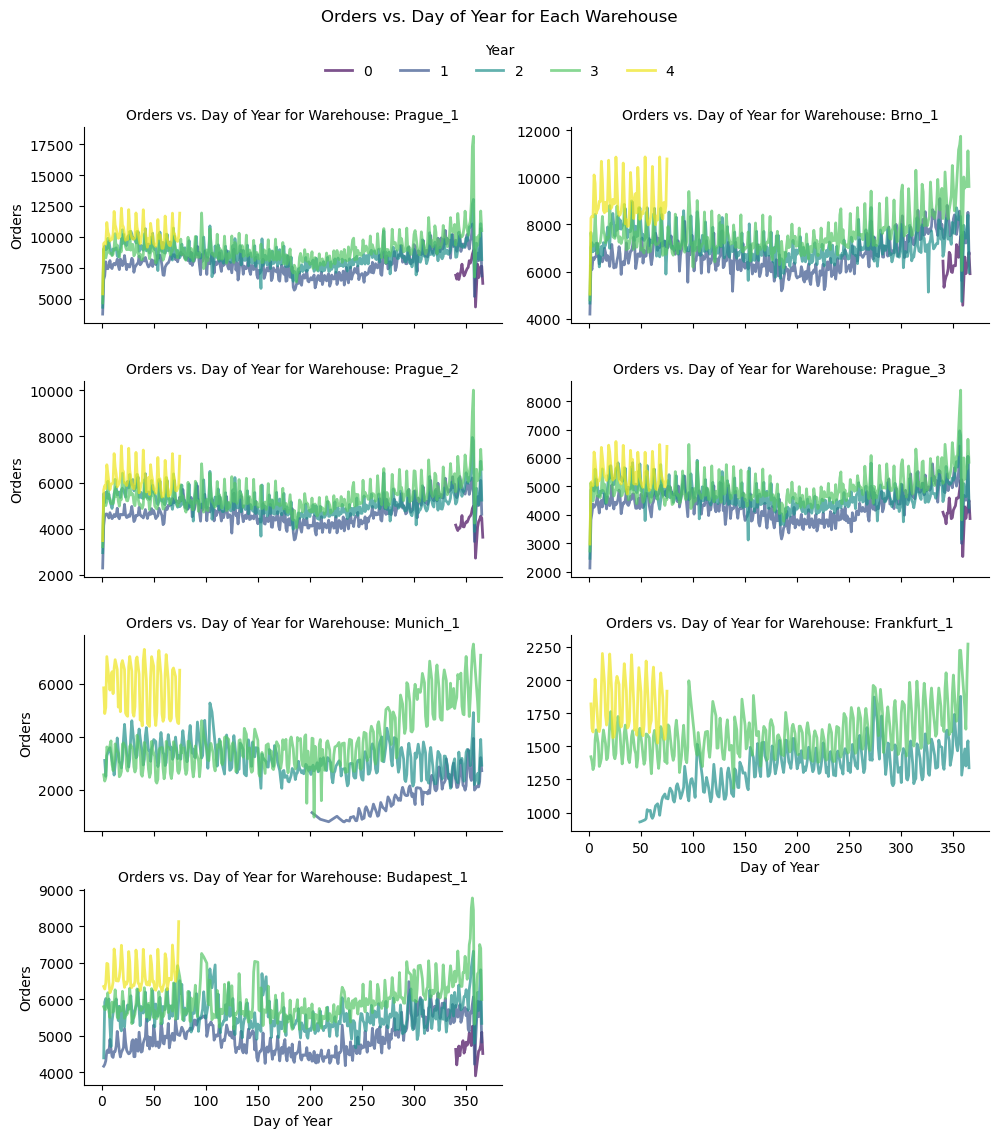

In [32]:
# Plot overlaid yearly series for each warehouse
g = sns.FacetGrid(
    train, col="warehouse", col_wrap=2, height=2.7, aspect=1.2, sharey=False
)

# Hacky approach to getting an even viridis palette
palette = {
    i: colour
    for i, colour in enumerate(sns.color_palette("viridis", n_colors=41)[0:41:10])
}
g.map_dataframe(
    sns.lineplot,
    x="dayofyear",
    y="orders",
    hue="year",
    palette=palette,
    linewidth=2,
    alpha=0.7,
    hue_order=range(5),
)

g.set_axis_labels("Day of Year", "Orders")
g.set_titles(col_template="Orders vs. Day of Year for Warehouse: {col_name}")
g.add_legend(
    title="Year",
    title_fontsize="13",
    bbox_to_anchor=(0.5, 1.03),
    loc="upper center",
    ncol=5,
)
g.fig.suptitle(
    "Orders vs. Day of Year for Each Warehouse", y=1.05
)  # Adjust y to fit title

plt.tight_layout()
plt.show()

### 3.3.3 Decomposition

We previously noted that there is a trend and a seasonal components to the order time series. Below, we decompose the time series into the observed, trend, seasonal (weekly, annual) and residual components. We use the MSTL method so that we can plot both cyclical components, which we show for the Brno_1 and Frankfurt_1 warehouses below. Note that we again choose to forward fill the missing order values.

We manipulate the MSTL parameters to generate simple and constant seasonal components. This is useful for visualising the common yearly and weekly components across the time course, but it increases the variation of the residuals because the seasonal component is not allowed to vary over time.

From an initial look at these results, we seem to effectively capture the trend and the weekly and yearly seasonalities. There is a fair bit of residual variance left over, though, so there may be patterns in these data beyond the trend and cycles. We may be able to generate forecasting models based on our other variables and/or lag features that can help capture the remaining order patterns.

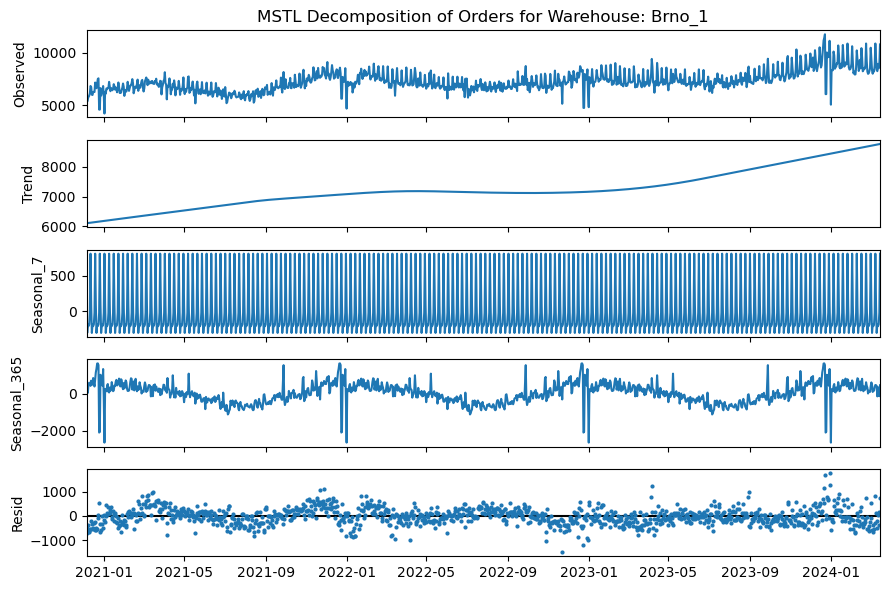

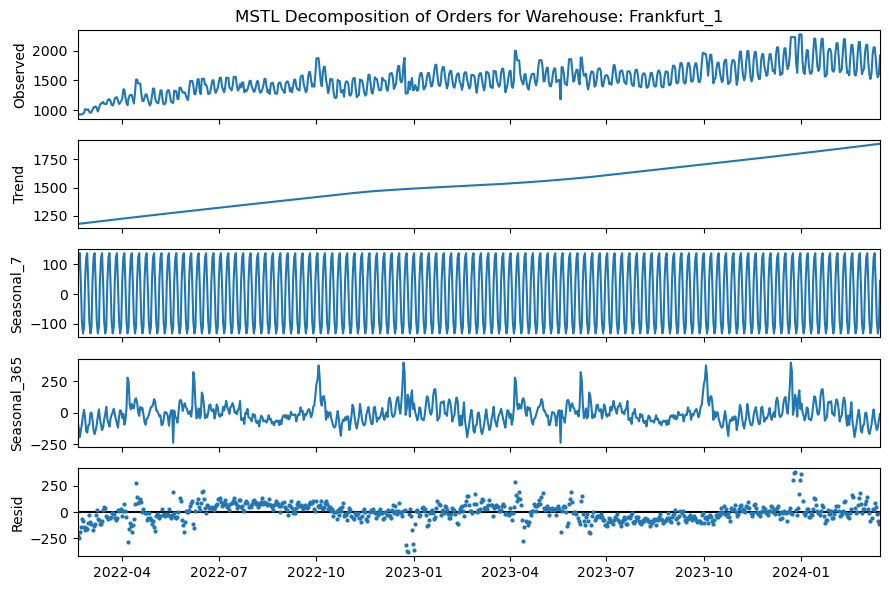

In [33]:
train = train.sort_index()

results = {}
warehouses_to_plot = ["Brno_1", "Frankfurt_1"]

for warehouse_name in train["warehouse"].unique():

    orders = train[train["warehouse"] == warehouse_name].copy().asfreq("D")
    orders = orders["orders"].ffill()  # Simple imputation

    # MSTL decomposition with two seasonal components (weekly and annual)
    # We set the window and seasonal degree to force the seasonality to be periodic
    # See: https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
    mstl = MSTL(
        orders, periods=[7, 365], windows=[10001, 10001], stl_kwargs={"seasonal_deg": 0}
    )
    results[warehouse_name] = mstl.fit()

    if warehouse_name not in warehouses_to_plot:
        continue

    # Plot the results
    fig = results[warehouse_name].plot()
    fig.set_size_inches(width, height)

    # Get smaller residual points
    for line in fig.axes[4].get_lines():
        line.set_markersize(2)

    fig.axes[0].set_title(
        f"MSTL Decomposition of Orders for Warehouse: {warehouse_name}"
    )
    fig.axes[0].set_ylabel("Observed")
    plt.tight_layout()
    plt.show()

It's difficult to make out the seasonal patterns in the plot above, so we plot them below for a single week / year for each warehouse. The yearly seasonalities generally capture the expected pattern (high, low, high across the year), although because we didn't apply smoothing it's quite sensitive to day-to-day variation. The yearly seasonal component also captures some of the holiday-related outliers (e.g., christmas and new years). 

There do seem to be weekly cycles in the yearly seasonality that haven't been captured in the weekly component. This may be because we are using a very simple model that assumes that the weekly seasonality remains the same across the time course.

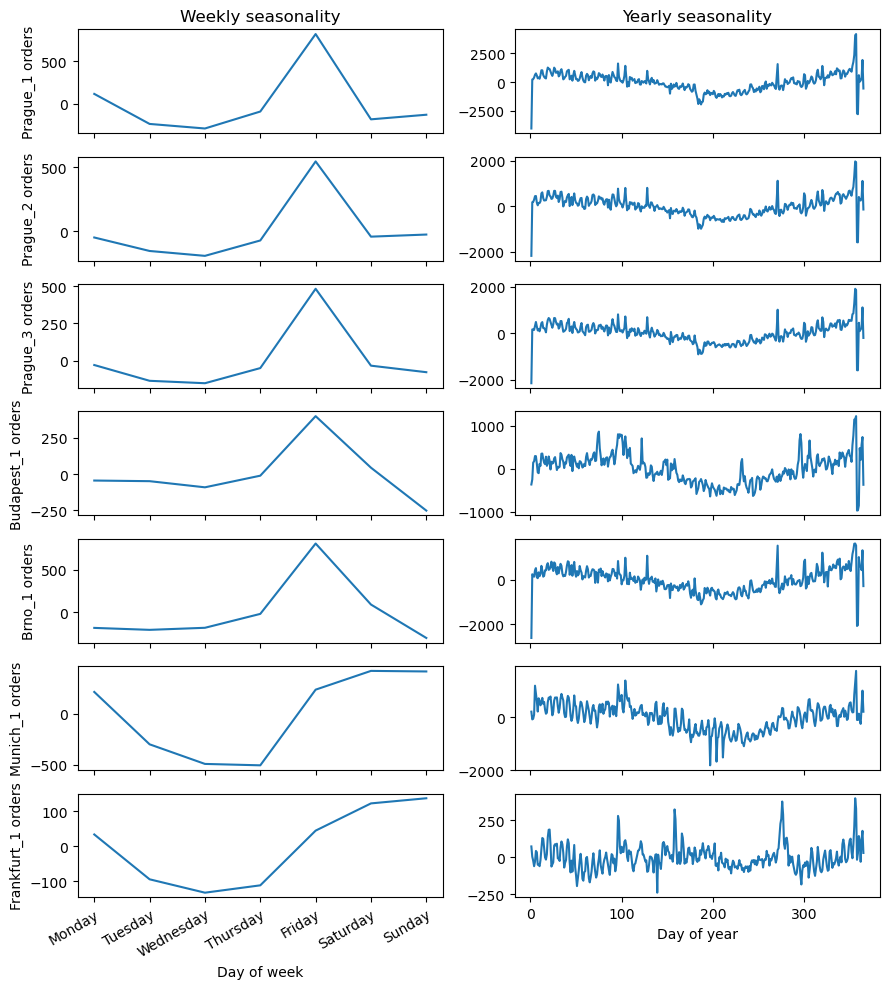

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=len(results), figsize=[width, 10])

# For each warehouse / plot row
for i, (ax_row, warehouse_name) in enumerate(zip(axes, results.keys())):

    # Weekly plot (all weeks are the same)
    weekly_res = (
        results[warehouse_name]
        .seasonal["seasonal_7"]["2023-01-02":"2023-01-08"]
        .to_frame()
    )

    weekly_res["dayofweek"] = weekly_res.index.dayofweek
    weekly_res.plot(x="dayofweek", y="seasonal_7", ax=ax_row[0], legend=False)

    ax_row[0].set_ylabel(f"{warehouse_name} orders")
    ax_row[0].set_xlabel("Day of week")
    ax_row[0].set_xticks(
        ticks=range(7),
        labels=[
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ],
    )
    ax_row[0].set_xticklabels(
        ax_row[0].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor"
    )

    # Yearly plot (all years are the same)
    yearly_res = (
        results[warehouse_name]
        .seasonal["seasonal_365"][results[warehouse_name].seasonal.index.year == 2023]
        .to_frame()
    )

    yearly_res["dayofyear"] = yearly_res.index.dayofyear
    yearly_res.plot(x="dayofyear", y="seasonal_365", ax=ax_row[1], legend=False)
    ax_row[1].set_xlabel("Day of year")

    # Add title to top of plot and axes to bottom
    if i == 0:
        ax_row[0].set_title("Weekly seasonality")
        ax_row[1].set_title("Yearly seasonality")
    else:
        ax_row[0].sharex(axes[0, 0])
        ax_row[1].sharex(axes[0, 1])


plt.tight_layout()
plt.show()

Below, we perform Augmented Dickey-Fuller (ADF) tests to check for stationarity of the series (i.e., the properties of the series do not depend on the time at which the series are observed). Stationary series do not have significant trend over time or changes in variance. This test is useful because it checks whether our decomposition approach above has managed to remove the trend properly; it will also tell us whether the series can be appropriately modelled by approaches that assume stationarity, like ARIMA. 

If we use a standard p-value threshold of 0.05, then most of the original time series are non-significant - i.e., we accept the null hypothesis that the series is non-stationary. However, post decomposition (i.e., the residual series), the test is significant for all the warehosues. Therefore, we can reject the null hypothesis, meaning that the series are likely stationary. 

In summary, the original series exhibit non-stationarity according to the ADF test (which we could already see, given the trend and cyclical components), but once we deal with these components the series is stationary. A model like SARIMA would be appropriate for our original series, because it could apply differencing to deal with the trend component while also capturing the seasonal component. However, most implementations of SARIMA only consider a single seasonality, so such a model might not be able to capture the yearly patterns. 

In [35]:
p_values = {"warehouse": [], "ADF_observed": [], "ADF_residual": []}

for warehouse_name, decomposition_result in results.items():

    # Perform ADF test for stationarity
    original_series_adf = adfuller(decomposition_result.observed, autolag="AIC")
    residual_series = adfuller(decomposition_result.resid, autolag="AIC")

    # Extract the p-values
    p_values["warehouse"].append(warehouse_name)
    p_values["ADF_observed"].append(original_series_adf[1])
    p_values["ADF_residual"].append(residual_series[1])

p_values_df = pd.DataFrame(p_values).set_index("warehouse")

print("ADF test p-values for the original and residual series")
p_values_df

ADF test p-values for the original and residual series


ADF_observed  ADF_residual
warehouse                              
Prague_1         0.362266  9.986997e-05
Prague_2         0.231853  7.972896e-06
Prague_3         0.277996  5.112100e-04
Budapest_1       0.777570  6.155165e-09
Brno_1           0.672071  2.052354e-04
Munich_1         0.655172  9.818157e-02
Frankfurt_1      0.195390  3.003463e-02

### 3.3.4 Autocorrelation

Autocorrelation plots tell us how a point in our time series is related to previous observations. However, variables can exhibit autocorrelation patterns due to trend or seasonal components, so it can also be useful to see if there are any dependencies separate from these components. Autocorrelation plots can help us decide on parameters to use for models like SARIMA. Such a model will deal with the trend (differencing) and seasonality (seasonal differencing) separately from the moving average / autoregressive components, which model the past errors and values of the series, respectively. So, the detrended autocorrelation patterns are likely more useful for deciding the parameters of this model.

Below, we plot the autocorrelation and partial autocorrelation for both the original series and a detrended series for which we have performed differencing to remove the trend and weekly cycle. We can see strong weekly autocorrelation patterns for the original series relative to the series with seasonal detrending. As expected, differencing greatly reduces the number of timepoints with strong autocorrelations, and we no longer see such strong weekly patterns in the seasonally detrended series. However, there is still a clear autocorrelation with the past week's lag, indicating that the seasonality is not completely accounted for. 

Regardless, given that there are number of lags with meaningful autocorrelations and partial autocorrelations for each warehouse, these results suggest it will be worth using a model that can take these into account over a simpler model that only models trend and seasonality, like ARIMA or SARIMA models. These models have a number of parameters that must be chosen, which is commonly done based on the autocorrelation plots. Some initial thoughts on these below.

ARIMA parameters:

 * **p**: Quite a few significant lags remain in the PACF plots after differencing, so this parameter is difficult to choose. It would be ideal to set this based on the warehouse, but it's common for the first week's lags to show meaningful partial autocorrelations after detrending. So `p` parameters between two and six may be sensible. Many warehouses show additional significant lags in the PACF longer than a week ago, so there could also be value in looking at greater orders.
 * **d**: A single difference plus a seasonal difference seems to be enough to deal with the trend components. The autocorrelations are typically non-significant after the first week. Furthermore, the AD fuller tests performed above were significant post-differencing.
 * **q**: After differencing, at least the first two or three lags tend to display significant negative autocorrelation. The `q` parameter probably needs to be altered based on the warehouse, but generally values between 2 and 8 might be reasonable. 


SARIMA seasonal parameters:

 * **P**: After seasonal differencing there usually remains two weekly points (i.e., lags 7 and 14) with significant partial autocorrelation. Therefore, it may make sense to set `P` to two.
 * **D**: As above.
 * **Q**: After seasonal differencing, the autocorrelation at lag 7 is usually significant, so a `Q` value of 7 seems reasonable.

We have multiple series to model, and there are quite a few lags with significant autocorrelations for most warehouses, making selection of the `p` parameter difficult. We could start off using lower values of `p` and `q`, then increase these parameters based on the residual lag correlations. Alternatively, since we have multiple series to model, it might make more sense to apply approaches like auto ARIMA, that picks the best models based on criteria like AIC. 

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


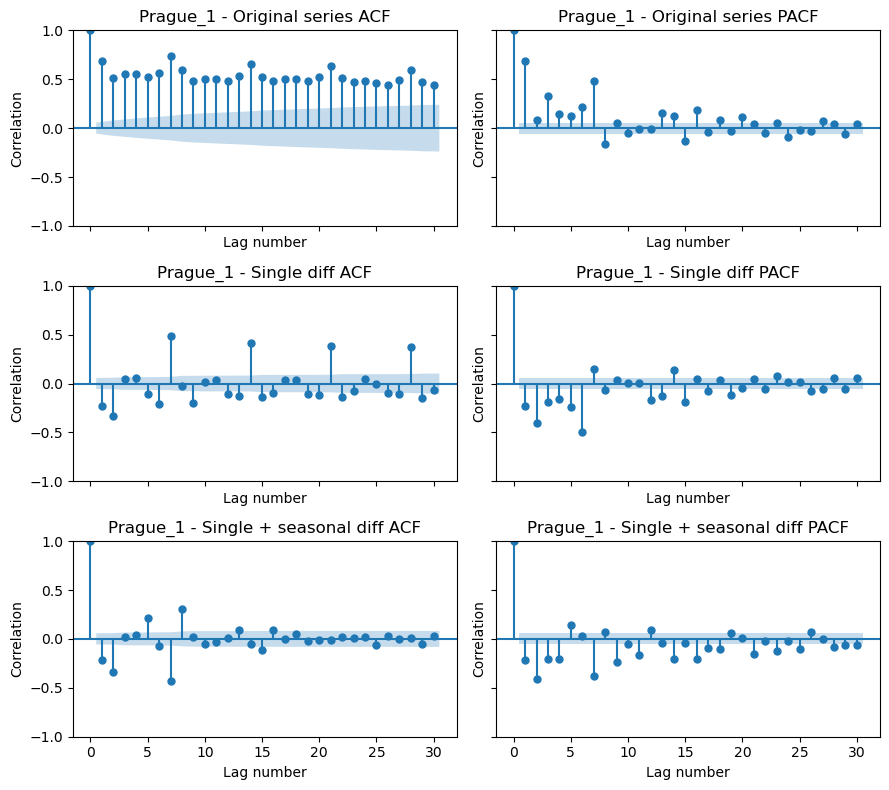

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


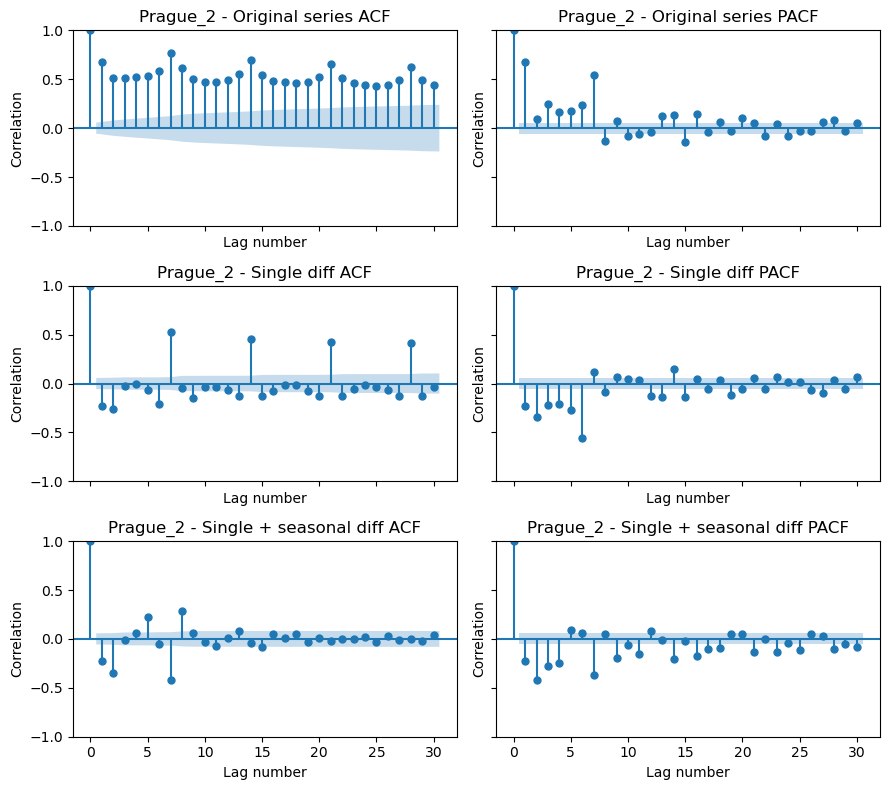

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


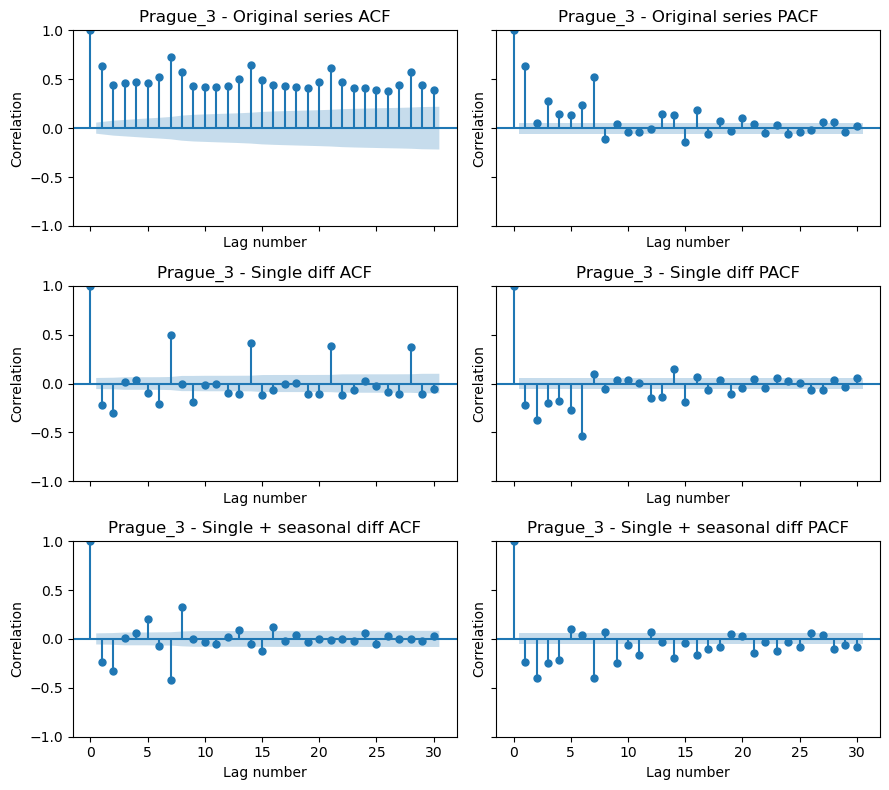

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


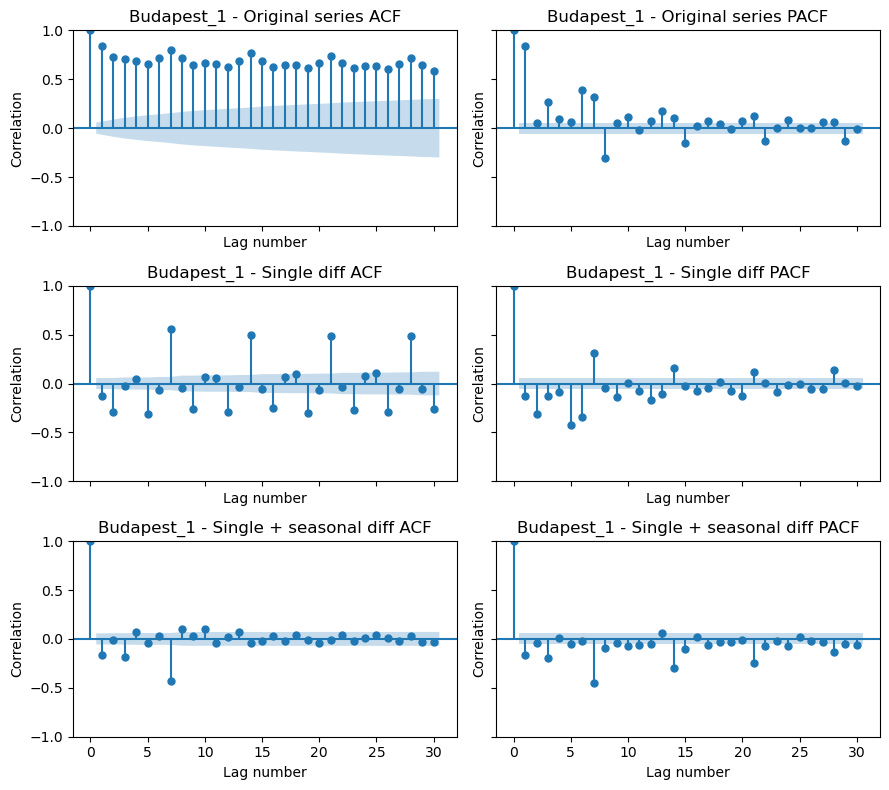

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


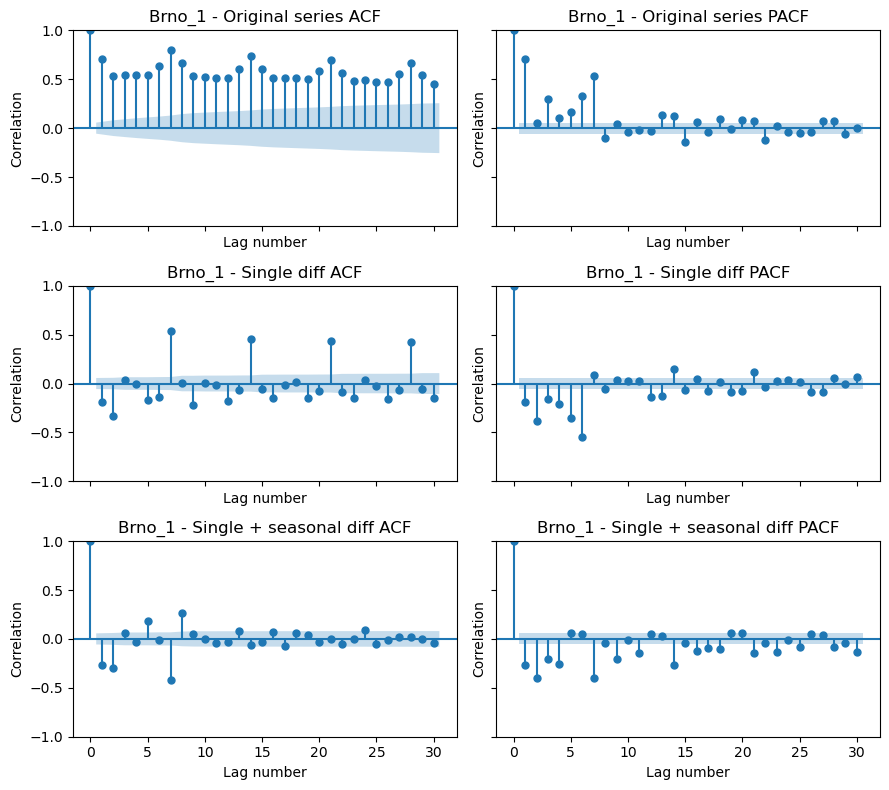

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


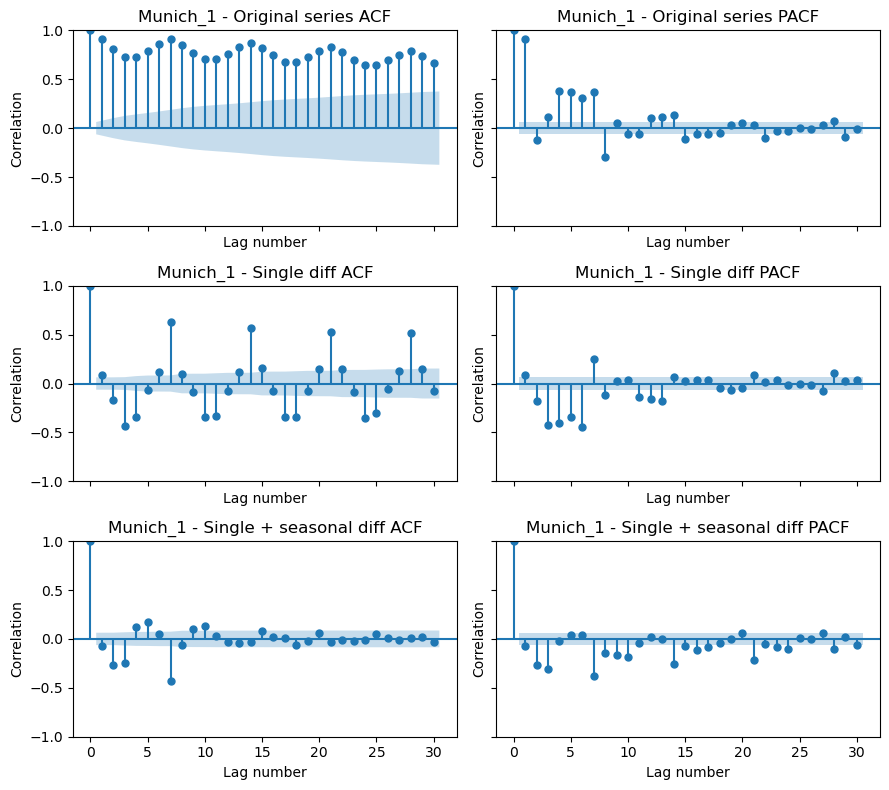

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\3667399822.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method="ffill")


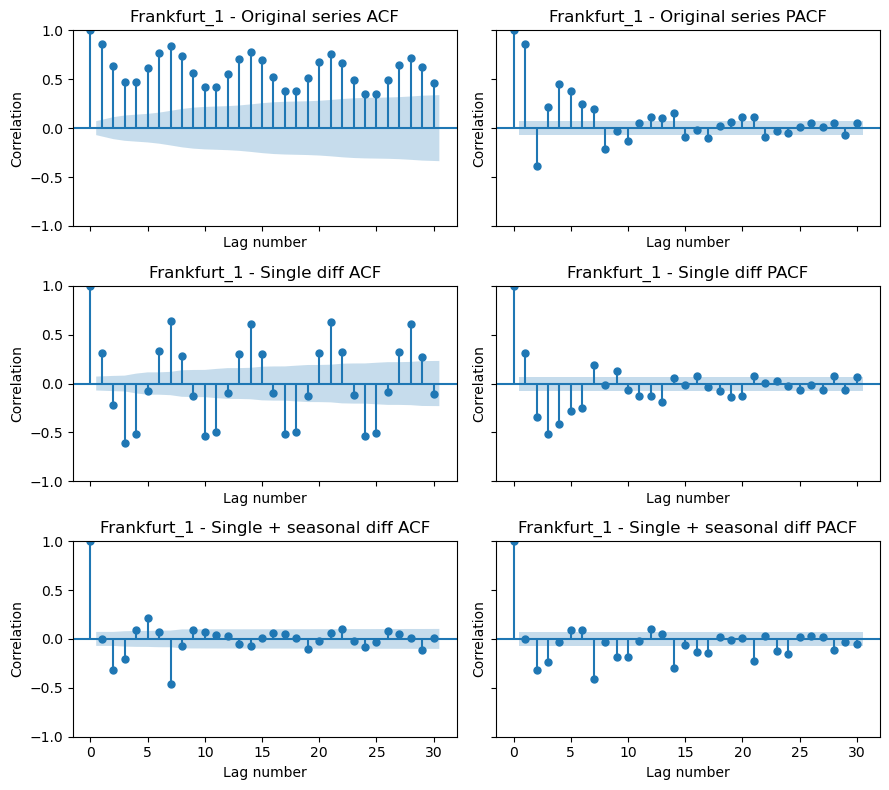

In [36]:
def diff_data(d, warehouse_name, periods):
    """Apply differencing of orders data for a given warehouse and set of diffs"""

    # Select the warehouse and apply simple imputation
    d = d.copy().reset_index()
    d = (
        d.loc[d["warehouse"] == warehouse_name, ["date", "orders"]]
        .set_index("date")
        .asfreq("D")
    )
    d = d.fillna(method="ffill")

    # Apply differencing
    d_diff = d.copy()
    for i in periods:
        d_diff = d_diff.diff(i)

    return d, d_diff.dropna()


def plot_autocorrelation(d, ax, series_name="Original", lags=30):
    """Plot the ACF/PACF for a given series"""

    plot_acf(d, ax=ax[0], lags=lags)
    ax[0].set_title(f"{warehouse_name} - {series_name} ACF")
    plot_pacf(d, ax=ax[1], lags=lags)
    ax[1].set_title(f"{warehouse_name} - {series_name} PACF")


for warehouse_name in train["warehouse"].unique():

    fig, axes = plt.subplots(3, 2, figsize=(width, height + 2), sharex=True, sharey=True)
    d, d_diff_single = diff_data(train, warehouse_name, periods = (1,))
    d, d_diff_seasonal = diff_data(train, warehouse_name, periods = (1, 7,))

    plot_autocorrelation(d, ax=axes[0, :].flat, series_name="Original series")
    plot_autocorrelation(d_diff_single, ax=axes[1, :].flat, series_name="Single diff")
    plot_autocorrelation(d_diff_seasonal, ax=axes[2, :].flat, series_name="Single + seasonal diff")

    for ax in axes.flatten():
        ax.set_ylabel("Correlation")
        ax.set_xlabel("Lag number")

    plt.tight_layout()
    plt.show()

# 4. Baselines and traditional modelling

## 4.1 Assessing the models

We have two DataFrames: `train`, containing labelled data, and `test`, containing our unlabelled data. We will ignore the test set, which spans a 61-day period, until we have validated our models and chosen the best approach. It's therefore important for us to create an internal labelled validation set in order to assess the performance of our forecasting models. We will split the data to achieve the following splits:

1. **train_internal** - This is the labelled data we will use to train our models on and optimise our hyperparameters. Within this split of the data, we will apply crossvalidation. Specifically, we will use approaches like `TimeSeriesSplit`, which ensures that testing data are always greater than before (i.e., occur chronologically after the training data).
2. **validate_internal** - This is labelled data that we will use to assess the performance of our optimised models. These data were originally part of the kaggle "train" set, but we will keep it as a labelled holdout set. It would have been ideal to create a validation set the same length of the test set, but we found that there was a change in series behaviour just before its start for some warehouses. We instead used a month-long validation set for the final model tests (~half the length of the test set) and note that a limitation of this approach is that the model performances estimated using this set may appear better than they would if we were to predict on a holdout set with the same horizon as the test set. For the more complex models models in this notebook, we optimised parameters based on a `TimeSeriesSplit` with 60-day windows, meaning they should be applicable to the longer horizon task. After assessing our models, we re-train them including this data split (i.e., with the entire labelled dataset) before assessing their performance on the test set.
3. **test** - This is the unlabelled kaggle test set which is only used for the final kaggle submission. This set spans from `2024-03-15` (60 days). 

For some of our models, such as the moving average approaches that require little in the way of parameter optimisation, we will simply train our forecaster on the "train" split and assess it on the "validate" set. For more complex models (e.g., SARIMA, XGBoost) we will apply cross-validation within the train set before assessing the model on the validation set.

In [189]:
# Add split columns
train.loc[:"2024-02-15", "split"] = "train_internal"
train.loc["2024-02-15":, "split"] = "validate_internal"
test["split"] = "test"

# Combine into one dataset before modelling
# We drop most of the train-only columns, although we keep user activity
train_only_columns_to_remove = [
    "blackout",
    "frankfurt_shutdown",
    "mini_shutdown",
    "precipitation",
    "shutdown",
    "snow",
]
data = pd.concat(
    [train.drop(train_only_columns_to_remove, axis=1, inplace=False), test]
)

The Kaggle competition uses the Mean Absolute Percentage Error (MAPE) to assess the submissions, defined below. This is essentially mean absolute error as a percentage (i.e., the error is normalised by the magnitude of the observed value). It might be that this error metric was chosen so that the series with higher average orders did not have an exaggerated effect on the metric. Alternatively, it might be that it was done because relative error was considered more important for this task. An error of 10 orders on a prediction of 1,000 orders might be considered good, but a 10-unit error on a prediction of 20 orders could be a problem!

In [190]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true)

## 4.2 Simple average

As our simplest baseline model we will simply use the average orders stratified by warehouse. Below, we calculate the average-per-warehouse. We do this on the internal training set first, and assess the performance of this "model" on the internal validation set (in terms of MAPE). Then we apply the averages calculated on the entire `train` DataFrame and use these to make our final predictions.

In [191]:
def get_data_split(d, splits=("train_internal", "validate_internal"), columns=None):
    """
    Takes a DataFrame, selects the required columns and subsets the rows based on the requested data split

    Parameters:
        d (pd.DataFrame): A DataFrame containing a "split" column indicating the data split

        splits (tuple): A tuple of strings indicating the splits to extract from `d`.

        columns (list): A list of columns to extract from `d`.

    Returns:
        pd.DataFrame: The input DataFrame `d` with row and column filtering applied.
    """

    if splits is not None:
        if isinstance(splits, str):
            splits = (splits,)

        d = d.copy()[d["split"].isin(splits)]

    if columns is None:
        columns = d.columns

    d = d[columns]

    return d


# Get the mean by warehouse for the internal and full training sets
mean_by_warehouse = {
    "train_internal": 
        get_data_split(data, splits="train_internal")
        .groupby("warehouse")["orders"]
        .mean(),
    "full_internal": 
        get_data_split(data, splits=("train_internal", "validate_internal"))
        .groupby("warehouse")["orders"]
        .mean(),
}

print("Mean by warehouse:")
mean_by_warehouse["full_internal"]

Mean by warehouse:


warehouse
Brno_1         7274.532272
Budapest_1     5555.864818
Frankfurt_1    1499.068362
Munich_1       3396.092994
Prague_1       8535.336966
Prague_2       5142.093043
Prague_3       4705.911148
Name: orders, dtype: float64

Below, we store the predictions of our models and check the error on the validation set. As we see below, we get roughly 20% error on the unseen data. All considered, this doesn't sound so bad for such a basic model!

In [192]:
# We store our predictions in a DataFrame across all models - one for the model trained on the internal train set, and another for the one trained on the full labelled dataset
all_predictions = {
    "train_internal": 
        data[["id", "warehouse", "split", "orders"]]
        .copy()
        .reset_index()
        .set_index("id")
}

all_predictions["full_internal"] = all_predictions["train_internal"].copy()


def add_predictions(all_predictions, data, new_predictions, model_name, model_type):
    """
    Adds a column to the predictions DataFrame

    Parameters:
        all_predictions (dict): A dictionary containing pd.DataFrame objects as values. Each DataFrame contains predictions for a time series.

        data (pd.DataFrame): The data from which the predictions were made.

        new_predictions (pd.Series): The predictions to be added to `all_predictions`.

        model_name (str): The name of the model from which predictions were generated.

        model_type (str): The type of model - i.e., the training split the model was trained on.

    Returns:
        pd.DataFrame: The input DataFrame `all_predictions` with an additional column of predictions.
    """

    data = data.copy().set_index("id")
    data[f"{model_name}_preds"] = new_predictions

    if f"{model_name}_preds" in all_predictions[model_type].columns:
        all_predictions[model_type] = all_predictions[model_type].drop(f"{model_name}_preds", axis=1)

    all_predictions[model_type] = all_predictions[model_type].join(
        data[[f"{model_name}_preds"]], how="left"
    )

    return all_predictions


# Get the predictions for each "models" train
for model_type in all_predictions.keys():
    
    all_predictions = add_predictions(
        all_predictions,
        data,
        new_predictions=data.set_index("id")["warehouse"].map(
            mean_by_warehouse[model_type]
        ),
        model_name="simple_mean",
        model_type=model_type,
    )

In [193]:
def get_validation_errors(all_predictions):
    """
    Gets the error on the validation set (using MAPE) for each model.

    Parameters:
        all_predictions (dict): A dictionary containing pd.DataFrame objects as values. Each DataFrame 
        contains predictions for a time series. Function expects that one of the dictionary keys is `train_internal`, 
        containing the model that has not seen the validation data. The DataFrame should contain a `splits` 
        column indicating the data split. Error is calculated for the "validate_internal" split.

    Returns:
        pd.DataFrame: A pd.DataFrame mapping model names (keys) to the MAPE (values).
    """

    val_predictions = all_predictions["train_internal"][
        all_predictions["train_internal"]["split"] == "validate_internal"
    ]

    validation_errors = pd.DataFrame(index=[model_name.removesuffix("_preds") for model_name in val_predictions.columns if model_name.endswith("_preds")], columns=val_predictions["warehouse"].unique(), dtype=np.float64)
    validation_errors["total"] = np.nan

    for model_name in validation_errors.index:
        for warehouse_name in validation_errors.columns:

            if warehouse_name == "total":
                val_predictions_warehouse = val_predictions
            else:
                val_predictions_warehouse = val_predictions[val_predictions["warehouse"] == warehouse_name]

            validation_errors.loc[model_name, warehouse_name] = MAPE(
                val_predictions_warehouse["orders"],
                val_predictions_warehouse[f"{model_name}_preds"],
            )

    return validation_errors


validation_errors = get_validation_errors(all_predictions)
validation_errors

Budapest_1  Prague_3  Prague_1  Frankfurt_1    Brno_1  Prague_2  \
simple_mean    0.172335   0.12318  0.149242     0.157317  0.180367      0.14   

             Munich_1    total  
simple_mean  0.391022  0.18427

And, finally, we plot out our predictions (for the Prague_1 and Munich_1 warehouses, as examples). We show the predictions of the model trained on the internal train set but not the internal labelled validation set ("Train-internal" model) and the full model that was trained on all the labelled data ("Full" model).

As expected, these "models" overestimate the earlier data and underestimate the more recent data (including the validation and test data). This is particularly apparent for the Munich_1 warehouse - the trend for this warehouse begins to rise rapidly towards the end of 2023, so the validation set takes on values far higher than the simple mean. This is reflected in the higher validation loss for this warehouse (MAPE > 0.4). Clearly, it would be more effective to incorporate the trend of the data, or even just use an average based on the more recent data. 

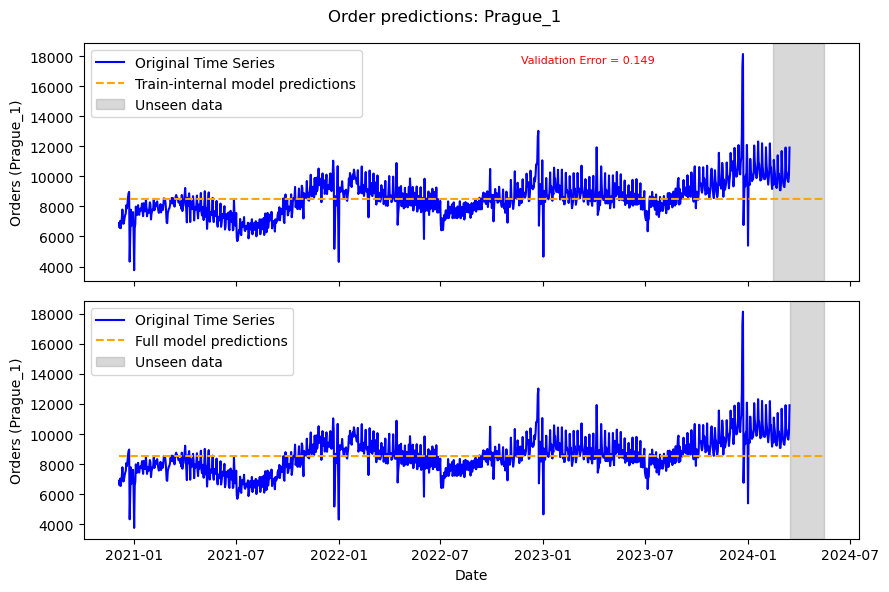

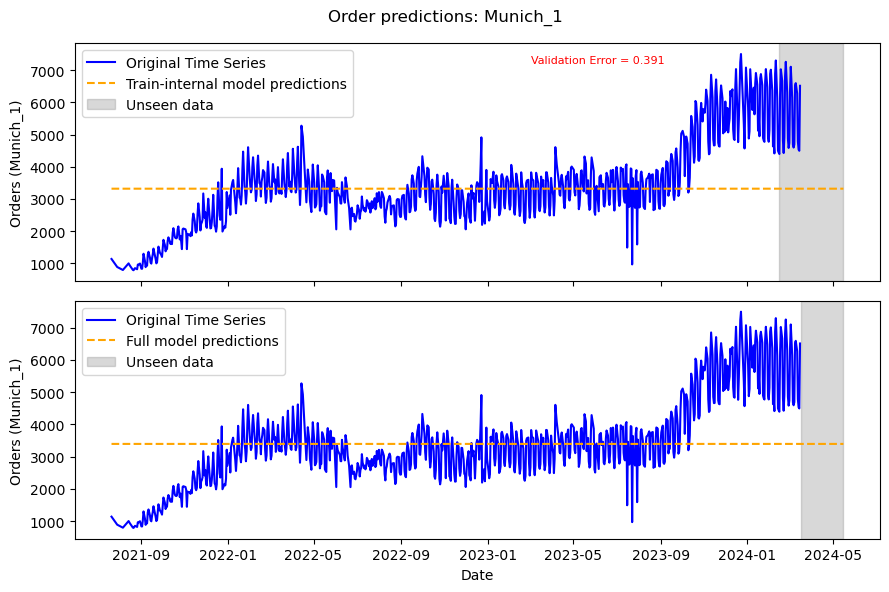

In [194]:
def make_prediction_plot(ts, preds, test_start, test_end, ax=None):
    """
    Makes a time series plot with the actual data with predictions overlaid.

    Parameters:
        ts (Series): The actual time series that is being forecasted.

        preds (Series): The predictions made for the series.

        test_range (str): A date range, in the format "XXXX-MM-DD:XXXX-MM-DD". Indicates the
        data being forecasted.

    Returns:
        A plot with the original time series and predictions overlaid.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Make the plots
    sns.lineplot(x=ts.index, y=ts, ax=ax, label="Original Time Series", color="blue")
    sns.lineplot(x=preds.index, y=preds, ax=ax, label="Predicted", color="orange", linestyle="--")
    # sns.lineplot(x=preds.index[preds.index < test_start], y=preds[preds.index < test_start], ax=ax, label="Fitted values", color="orange", linestyle="--")
    # sns.lineplot(x=preds.index[preds.index >= test_start], y=preds[preds.index >= test_start], ax=ax, label="Forecast", color="red", linestyle="--")

    # Highlight the test range
    ax.axvspan(test_start, test_end, color="gray", alpha=0.3, label="Unseen data")

    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.legend()

    if ax is None:
        plt.show()

    return ax


def plot_order_predictions(data, all_predictions, model_name, warehouses=None):
    """
    Calls the  `make_prediction_plot` function to create plots for each of the
    "train_internal" (i.e., trained on the internal train set) and "full_internal" 
    (i.e., trained on the full labelled dataset) models.

    Parameters:
        data (pd.DataFrame): DataFrame including the orders outcome and a DateTimeIndex.

        all_predictions (pd.DataFrame): DataFrame of predictions for each model.

        model_name (str): The name of the model to be plotted.

        warehouses (tuple): Which warehouses to plot time series for. If None, plots all warehouses.
    """

    if isinstance(warehouses, str):
        warehouses = (warehouses,)

    # Ensure inputs match
    for model_type in all_predictions.keys():
        assert (data["id"] == all_predictions[model_type].index).all()

    # Get date ranges for val/test
    val_dates = data["split"].index[data["split"] == "validate_internal"].unique()
    test_dates = data["split"].index[data["split"] == "test"].unique()

    # Make plots for each warehouse
    if warehouses is None:
        warehouses = data["warehouse"].unique()

    for warehouse in warehouses:

        # Make the plots for both models for a given warehouse
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(width, height), sharex=True)

        orders = data["orders"][data["warehouse"] == warehouse]
        order_preds = {}

        for model_type in all_predictions.keys():
            order_preds[model_type] = all_predictions[model_type][all_predictions[model_type]["warehouse"] == warehouse].set_index("date")[f"{model_name}_preds"]
            assert (order_preds[model_type].index == orders.index).all()

        # Model trained on just the internal train set
        axes[0] = make_prediction_plot(
            orders, 
            order_preds["train_internal"],
            test_start=val_dates.min(),
            test_end=test_dates.max(),
            ax=axes[0]
        )
        axes[0].lines[1].set_label("Train-internal model predictions")

        # Annotate the prediction error for the warehouse
        val_error = MAPE(orders[orders.index.isin(val_dates)], order_preds["train_internal"][order_preds["train_internal"].index.isin(val_dates)])

        axes[0].annotate(
            f"Validation Error = {val_error:.3f}",
            xy=(0.65, 0.95),  
            xycoords="axes fraction", 
            fontsize=8,
            color="red",
            ha="center", 
            va="top" 
        )

        # Model trained on the full dataset
        axes[1] = make_prediction_plot(
            orders, 
            order_preds["full_internal"],
            test_start=test_dates.min(),
            test_end=test_dates.max(),
            ax=axes[1]
        )
        axes[1].lines[1].set_label("Full model predictions")

        # Change titles, update legend and plot
        axes[0].set_ylabel(f"Orders ({warehouse})"), axes[1].set_ylabel(f"Orders ({warehouse})")
        fig.suptitle(f"Order predictions: {warehouse}")
        axes[0].legend()
        axes[1].legend()

        plt.tight_layout()
        plt.show()


plot_order_predictions(data, all_predictions, "simple_mean", warehouses=("Prague_1", "Munich_1"))

Finally, below we reformat the predictions as expected by Kaggle in preparation for submission. This model had public and private scores of 17.6% and 20.8%, respectively. So, the model performs very similarly on the test data as it did on the validation data. 

In [196]:
def predictions_to_submission(all_predictions, model_name, model_type, solution_format=original_data["solution_example"], file_path=None):
    """
    Takes the model predictions and ensures they are in the format expected by Kaggle.

    Parameters:
        all_predictions (dict): A dictionary containing pd.DataFrame objects as values. Each DataFrame 
        contains predictions for a time series.

        model_name (str): The name of the model from which predictions were generated.

        model_type (str): The type of model - i.e., the training split the model was trained on.

        solution_format (pd.DataFrame): A DataFrame that is in the format expected by Kaggle.

        file_path (str): A string or filepath object indicating the path at which to save the submission as a CSV.

    Returns:
        pd.DataFrame: A DataFrame in the format expected by Kaggle.
    """

    preds = all_predictions[model_type].copy()
    solution_format = solution_format.copy().set_index("id")

    preds = preds[preds.index.isin(solution_format.index)]
    assert (preds.index == solution_format.index).all()

    preds = preds.reset_index()[["id", f"{model_name}_preds"]]

    if file_path:
        preds.to_csv(file_path, index=False)

    return preds


# Here, we get the predictions for the final simple mean "model" that was "trained" on the full labelled dataset
predictions_to_submission(all_predictions, model_name="simple_mean", model_type="full_internal").head()

id  simple_mean_preds
0  Prague_1_2024-03-16        8535.336966
1  Prague_1_2024-03-17        8535.336966
2  Prague_1_2024-03-18        8535.336966
3  Prague_1_2024-03-19        8535.336966
4  Prague_1_2024-03-20        8535.336966

## 4.3 Exponential moving average

So, the simple average is clearly not an optimal model. We could get a far better baseline model simply by forecasting the last observed value in the series. Below, we will apply exponential smoothing models. These should give us far better predictions. A simple order-1 smoother can give us the average of the series for the most recent data and use this as a forecast, which will already be a great improvement on the simple average. More complex smoothers will take into account the seasonality of the data.

For these models, we have to pick values that control the level of smoothing. High values will lead to models that fit the data tighly, but these may not perform well on unseen data. Below, we train models on the internal train set and check their error (MAPE) on the internal validation set. We pick the model with the lowest error and move forward with it. Then we plot out the forecast for this model along with a model that is additionally trained on the validation set.

The limitation of this approach is that our smoothers will likely have a better performance on the validation set than they would on unseen data. While the smoother does not see the validation set directly, we will have used it to optimise the model parameters. A better method would have been to perform cross-validation within the internal training set to select smoothing parameters, then check its performance on the validation set. We will do this for more complex models later on in this notebook. For now, the more simple approach will give us a reasonable idea of how our models perform on new data, and we can check their performance on completely new data after we submit their forecasts to Kaggle.

In [197]:
def fit_smoother_by_warehouse(data, fit_params, splits=("train_internal", "validate_internal"), outcome="orders", **kwargs):
    """
    Apply exponential smoothing to time series data by warehouse.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the time series data, with a 'warehouse' column, DateTimeIndex, and outcome column.

        fit_params (dict): Parameters to be passed to the fit method of `ExponentialSmoothing`.

        splits (tuple): Tuple of data splits to use for training (default is ("train_internal", "validate_internal")).
        
        outcome (str): The outcome to forecast (default is 'orders').

        kwargs: Additional arguments to be passed to `ExponentialSmoothing`.

    
    Returns:
        DataFrame with predictions for the entire input data, including both fitted and forecasted values.
    """

    if isinstance(splits, str):
        splits = (splits,)

    warehouse_predictions = []
    
    # Iterate over each warehouse
    for warehouse_name, warehouse_data in data.groupby('warehouse'):
        
        # Split the data into training and forecasting sets
        train_data = warehouse_data[warehouse_data['split'].isin(splits)].asfreq("D")
        test_data = warehouse_data[~warehouse_data['split'].isin(splits)].asfreq("D")

        # Interpolate the training data where we have missing values
        train_data[outcome] = train_data[outcome].fillna(method="ffill")
        test_data[outcome] = np.nan
        
        # Fit the model and predict/forecast
        model = ExponentialSmoothing(train_data[outcome], **kwargs).fit(**fit_params)
        train_predictions = model.fittedvalues
        test_predictions = model.forecast(len(test_data))
        
        # Combine the predictions with the original data
        predictions = pd.concat([train_predictions, test_predictions], axis=0)
        predictions.name = f"{outcome}_preds"
        full_predictions = pd.concat([warehouse_data, predictions], axis=1)
        warehouse_predictions.append(full_predictions.set_index("id")[f"{outcome}_preds"])
    
    return pd.concat(warehouse_predictions)


smooth_configs = {
    "exp_single": {"trend": None, "seasonal": None},
    "exp_double": {"trend": "add", "seasonal": None},
    "exp_triple_add": {"seasonal_periods": 7, "trend": "additive", "seasonal": "additive"},
    "exp_triple_mult": {"seasonal_periods": 7, "trend": "multiplicative", "seasonal": "multiplicative"},
    "exp_triple_add_damptrend": {"seasonal_periods": 7, "trend": "additive", "seasonal": "additive", "damped_trend": True},
    "exp_triple_mult_damptrend": {"seasonal_periods": 7, "trend": "multiplicative", "seasonal": "multiplicative", "damped_trend": True},
    "exp_triple_add_notrend": {"seasonal_periods": 7, "trend": None, "seasonal": "additive"},
    "exp_triple_mult_notrend": {"seasonal_periods": 7, "trend": None, "seasonal": "multiplicative"}
}


def get_fit_config(optimized=False):
    """Get random smoothing parameters to be tested"""

    if optimized:
        # Let model optimize itself
        fit_config = {"optimized": True}
    else:
        # Randomly select parameters
        fit_config = {
            "optimized": False, 
            "smoothing_level": np.random.uniform(0, 1), 
            "smoothing_trend": np.random.uniform(0, 1), 
            "damping_trend": np.random.uniform(0, 1), 
            "smoothing_seasonal": np.random.uniform(0, 1)
        }

    return fit_config


n_runs = 100  # Number of randomly-initialised smoothing parameters to try
best_fit_configs = {}  # The best smoothing parameters (by MAE on the validation set)

# For each type of exponential model
for model_name, smooth_config in smooth_configs.items():

    # Use random optimisation of smoothing levels on the validation set and pick the one with the best MAPE
    np.random.seed(1)
    best_fit_configs[model_name], best_error = None, np.inf

    for i in range(n_runs):
        
        # Get the config and apply smoothing
        if i == 0:
            fit_config = get_fit_config(optimized=True)
        else:
            fit_config = get_fit_config(optimized=False)

        exp_smooth_preds = fit_smoother_by_warehouse(
            data,
            fit_params=fit_config,
            splits="train_internal", 
            outcome="orders",
            **smooth_config
        )

        # Calculate error and save parameters if they are superior
        val_idx = data.set_index("id")["split"] == "validate_internal"
        val_error = MAPE(data.set_index("id")["orders"][val_idx], exp_smooth_preds[val_idx])

        if val_error < best_error:
            best_fit_configs[model_name] = fit_config
            best_error = val_error

    # Get the predictions of the optimised model (including both the train-internal model and the full model)
    for model_type in all_predictions.keys():
        
        # Select the correct data split
        if model_type == "train_internal":
            splits = "train_internal"
        else:
            splits = ("train_internal", "validate_internal")

        # Apply the model
        exp_smooth_preds = fit_smoother_by_warehouse(
            data,
            fit_params=best_fit_configs[model_name],
            splits=splits, 
            outcome="orders",
            **smooth_config
        )

        # Add the predictions to the predictions DataFrame
        all_predictions = add_predictions(
            all_predictions,
            data,
            new_predictions=exp_smooth_preds,
            model_name=model_name,
            model_type=model_type,
        )

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2632556939.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data[outcome] = train_data[outcome].fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2632556939.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data[outcome] = train_data[outcome].fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2632556939.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data[outcome] = train_data[outcome].fillna(method="ffill")
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\2632556939.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill()

Below, we see that the exponential models are greatly outperforming the simple mean approach. The simple single-order smoother has a MAPE of <8%, less than half the error of the simple mean approach.

<Axes: >

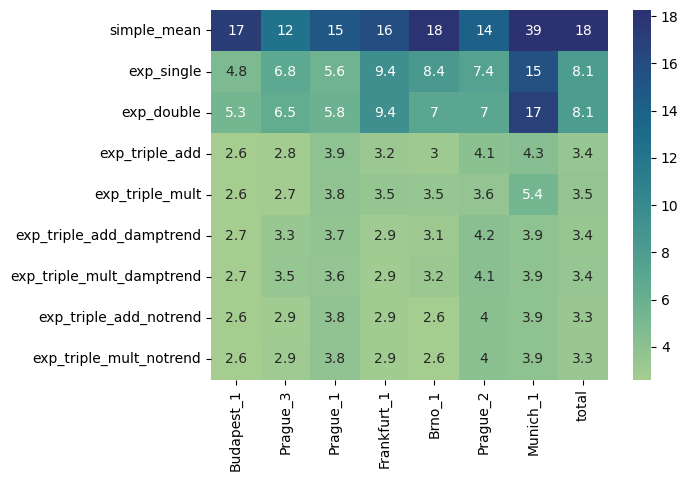

In [198]:
val_errors = get_validation_errors(all_predictions)
sns.heatmap(val_errors * 100, annot=True, cmap=sns.color_palette("crest", as_cmap=True), robust=True)

Interestingly, the order-2 smoother, which has a trend component, is actually worse than the simpler model. The plots below, for the Munich_1 warehouse, suggest why this might be. The plots indicate the fitted values for the data the model was trained on, and the forecasts for future data (shaded in gray). For the Munich warehouse, there is a large increase in orders, which starts to flatten out as we reach the validation set. The trend line suggests the trend will continue, but since it doesn't the validation error is higher. 

Single exponential model:

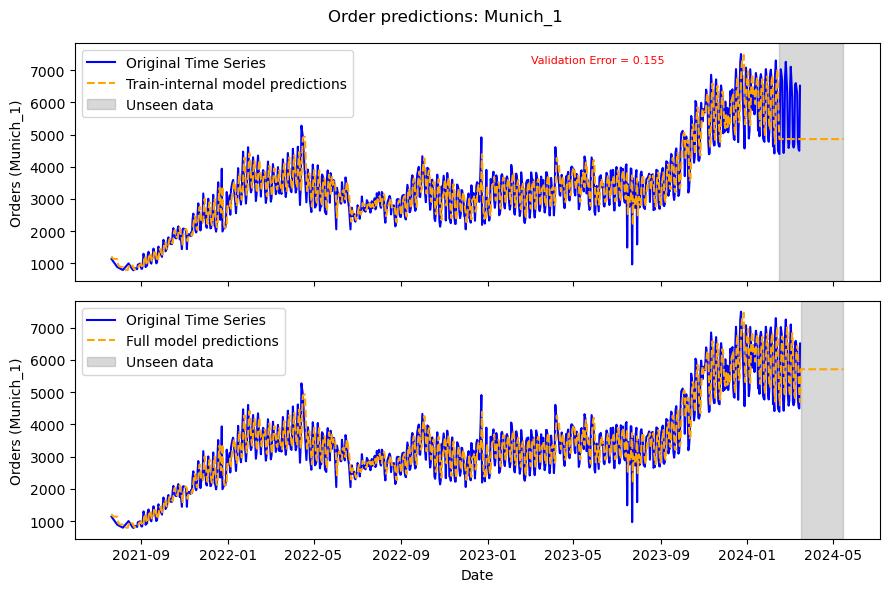

In [199]:
plot_order_predictions(data, all_predictions, "exp_single", warehouses="Munich_1")

Double exponential model:

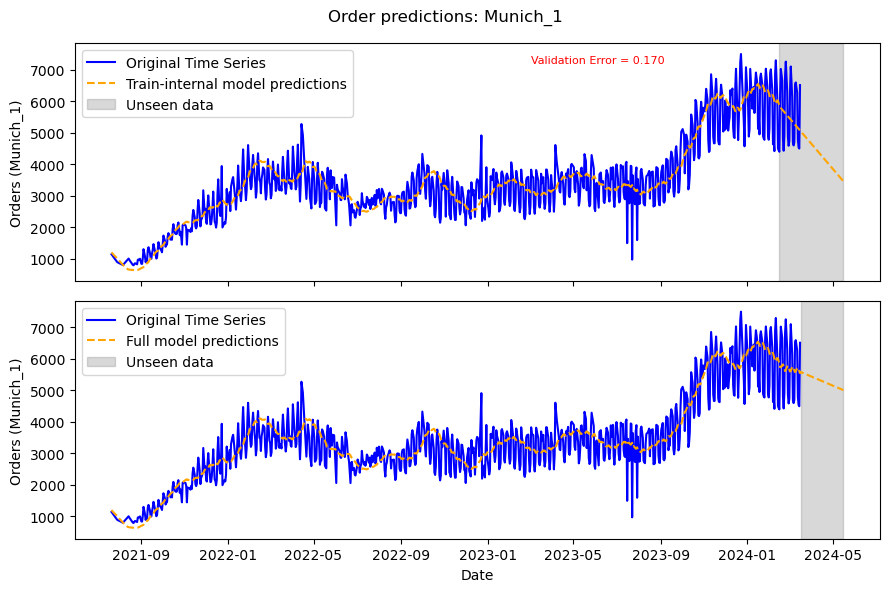

In [200]:
plot_order_predictions(data, all_predictions, "exp_double", warehouses="Munich_1")

The triple exponential models performed the best - they are able to capture the seasonal variation, which is a consistent pattern across the dataset. Therefore, they have a lower validation error.

The models with an undampened trend component perform the worst of these (6 to 8% MAPE), but are still better than the single and double exponential approaches. The remaining models with no trends or dampened trends have similar errors regardless of whether the trend and seasonal components are additive or multipilicative (~5%). The dampening parameter for the best model was very high, so these models are fairly similar.

We show the trendless model (multiplicative) below, for the Prague_1 and Munich_1 warehouses

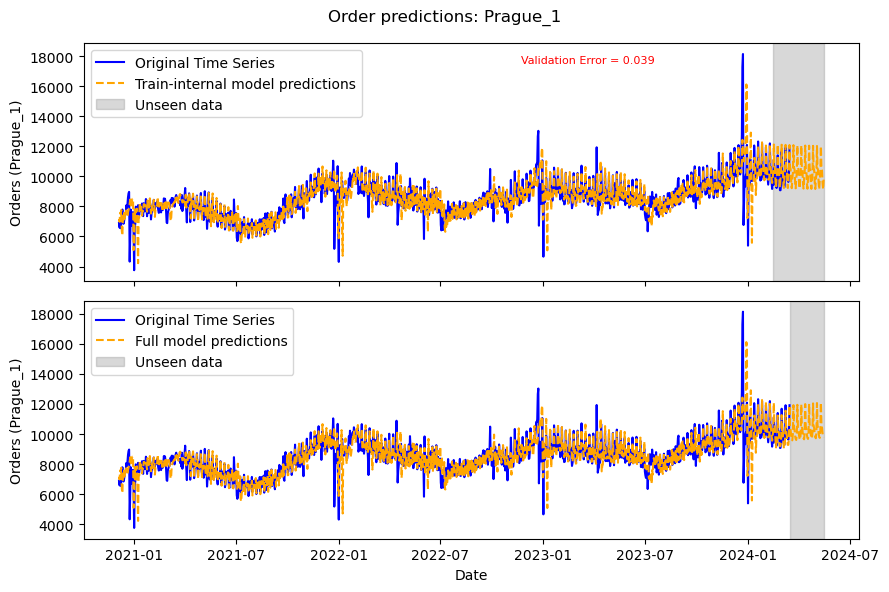

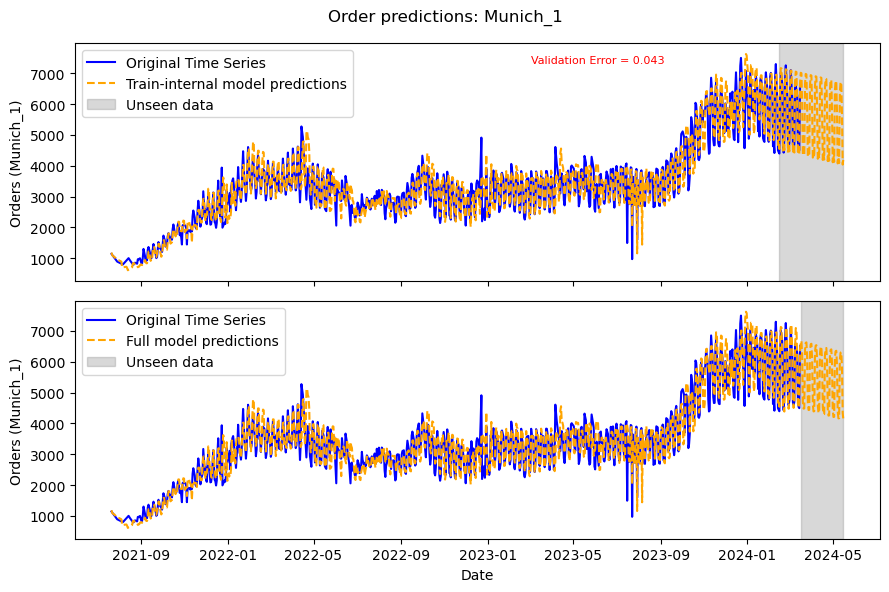

In [201]:
plot_order_predictions(data, all_predictions, "exp_triple_add", warehouses=("Prague_1", "Munich_1"))

Obviously, the trendless models assume that the data remains stationary with no trend. This assumption will surely fail over longer periods of time, but they will do very well over shorter periods given that there are no unexpected rises or falls in the total orders. Next, we will move on to more complex models that may perform better over longer periods (e.g., ARIMA). But for now, the exponential models are useful as a baseline. 

We move forward with this model and submit the predictions to Kaggle. The model has a private and public score of 5.6% and 4.8%, respectively. This is very similar to our validation MAPE, so it seems that our validation procedure is working well to assess the performance of our models on unseen data. These models would have put us at position 461/1017 on the private leaderboard. So, these relatively simple models are already better than average! The best submission achieved a score of 3.6%, so the exponential smoothers aren't far off that of far more complex models that have access to additional data (e.g., holidays). 

In [202]:
predictions_to_submission(all_predictions, model_name="exp_triple_mult_notrend", model_type="full_internal").head()

id  exp_triple_mult_notrend_preds
0  Prague_1_2024-03-16                   10416.739744
1  Prague_1_2024-03-17                   10236.337028
2  Prague_1_2024-03-18                    9809.513014
3  Prague_1_2024-03-19                    9557.808501
4  Prague_1_2024-03-20                    9516.225517

## 4.4 ARIMA/SARIMA (manual model specification)

In [203]:
def fit_arima_by_warehouse(data, splits=("train_internal", "validate_internal"), outcome="orders", **kwargs):
    """
    Apply exponential smoothing to time series data by warehouse.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the time series data, with a 'warehouse' column, DateTimeIndex, and outcome column.

        splits (tuple): Tuple of data splits to use for training (default is ("train_internal", "validate_internal")).
        
        outcome (str): The outcome to forecast (default is 'orders').
    
    Returns:
        A tuple containing:
         * 0: DataFrame with predictions for the entire input data, including both fitted and forecasted values.
         * 1: A dictionary containing warehouses as keys and fitted `SARIMAX` models as values.
    """
        
    if isinstance(splits, str):
        splits = (splits,)

    warehouse_predictions, warehouse_models = [], {}
    
    # Iterate over each warehouse
    for warehouse_name, warehouse_data in data.groupby('warehouse'):

        # Interpolate and apply differencing
        warehouse_data = warehouse_data.sort_index()
        warehouse_data[outcome] = warehouse_data[outcome].fillna(method="ffill").dropna()
        
        # Split the data into training and forecasting sets
        train_data = warehouse_data[warehouse_data['split'].isin(splits)].asfreq("D")
        test_data = warehouse_data[~warehouse_data['split'].isin(splits)].asfreq("D")
        test_data[outcome] = np.nan
        
        # Fit the model and predict
        model = SARIMAX(train_data[outcome], **kwargs)
        fitted_model = model.fit(disp=False)
        warehouse_models[warehouse_name] = fitted_model
        
        train_predictions = fitted_model.fittedvalues
        test_predictions = fitted_model.forecast(len(test_data))
        
        # Combine the predictions with the original data
        predictions = pd.concat([train_predictions, test_predictions], axis=0)
        predictions.name = f"{outcome}_preds"
        full_predictions = pd.concat([warehouse_data, predictions], axis=1)
        
        warehouse_predictions.append(full_predictions.set_index("id")[f"{outcome}_preds"])
    
    return pd.concat(warehouse_predictions), warehouse_models


# Parameters based on autocorrelation (see end of data exploration section) and residual correlograms (below)
arima_orders = {
    "standard_arima": (6, 1, 6, 0, 0, 0, 0),
    "standard_arima_nodiff": (6, 1, 6, 0, 0, 0, 0),
    "seasonal_arima": (6, 1, 6, 2, 1, 1, 7),
    "seasonal_arima_nodiff": (6, 1, 6, 2, 1, 0, 7) 
}

arima_models = {}

# For each order tuple:
for model_name, orders in arima_orders.items():

    # Train a model with these orders 
    for model_type in all_predictions.keys():
        
        # Select the correct data split
        if model_type == "train_internal":
            splits = "train_internal"
        else:
            splits = ("train_internal", "validate_internal")

        # Apply the model
        arima_preds, arima_model = fit_arima_by_warehouse(
            data, 
            splits=splits, 
            outcome="orders", 
            order=orders[0:3],
            seasonal_order=orders[3:], 
            enforce_stationarity=True, 
            enforce_invertibility=True
        )

        if model_type == "train_internal":
            arima_models[model_name] = arima_model

        # Add the predictions to the predictions DataFrame
        all_predictions = add_predictions(
            all_predictions,
            data,
            new_predictions=arima_preds,
            model_name=model_name,
            model_type=model_type,
        )

C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\166131284.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  warehouse_data[outcome] = warehouse_data[outcome].fillna(method="ffill").dropna()
c:\ProgramData\miniconda3\envs\20240819_kaggle\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jack Gisby\AppData\Local\Temp\ipykernel_21012\166131284.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  warehouse_data[outcome] = warehouse_data[outcome].fillna(method="ffill").dropna()
c:\ProgramData\miniconda3\envs\20240819_kaggle\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

We stored the models trained for each model. Let's look at some diagnostic plots for the Prague 1 warehouse as an example. Below we can see the diagnostic plot for the non-seasonal (ARIMA) and seasonal (SARIMA) models, including a plot of the residuals and a correlogram for the lags. If we've modelled effectively, we should hope to see near-zero correlations for all the lags. 

While this is the case, there are some sizeable outliers in the residual plot, particularly around the start/end of the year. These are, of course, the holidays that we have failed to account for in these models. We may be able to add exogenous variables using ARIMAX/SARIMAX to deal with these days.

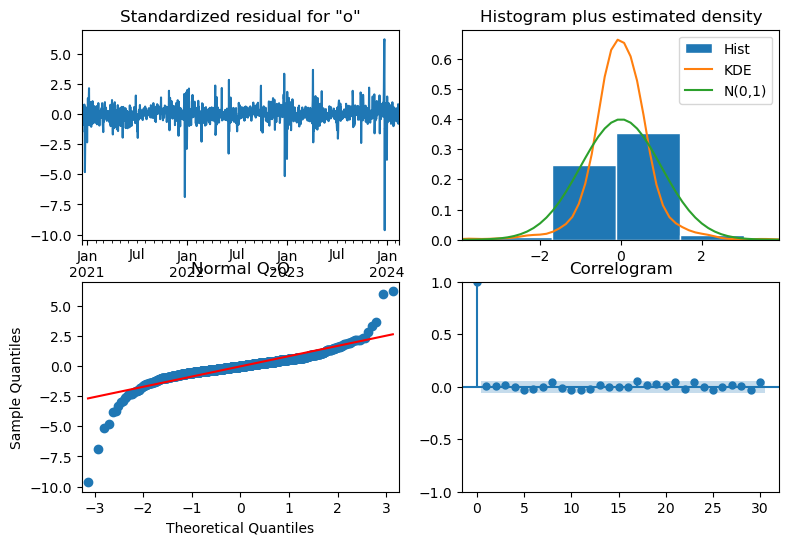

In [ ]:
fig = arima_models["seasonal_arima"]["Prague_1"].plot_diagnostics(figsize=(width, height), lags=30)
plt.show()

Below, we can see the MAPE for both ARIMA and SARIMA, compared to all of our previous models. Unfortunately, the ARIMA models tend to do worse than the trendless exponential models.

<Axes: >

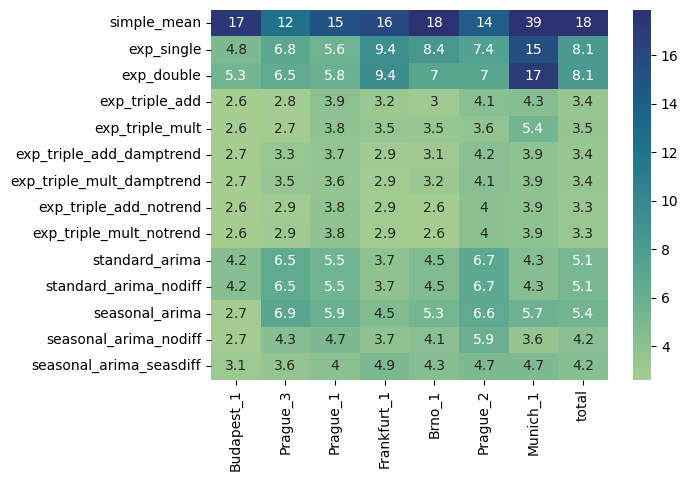

In [ ]:
val_errors = get_validation_errors(all_predictions)
sns.heatmap(val_errors * 100, annot=True, cmap=sns.color_palette("crest", as_cmap=True), robust=True)

We can see the predictions for the SARIMA models below. The model seems to capture the seasonal patterns well, but is let down by the inconsistent trend in the validation set., particularly for the Munich_1 warehouse. For most warehouses, the ARIMA models are better than the exponential moving average models. However, they are let down by their extrapolation of the Munich trend into the validation set.

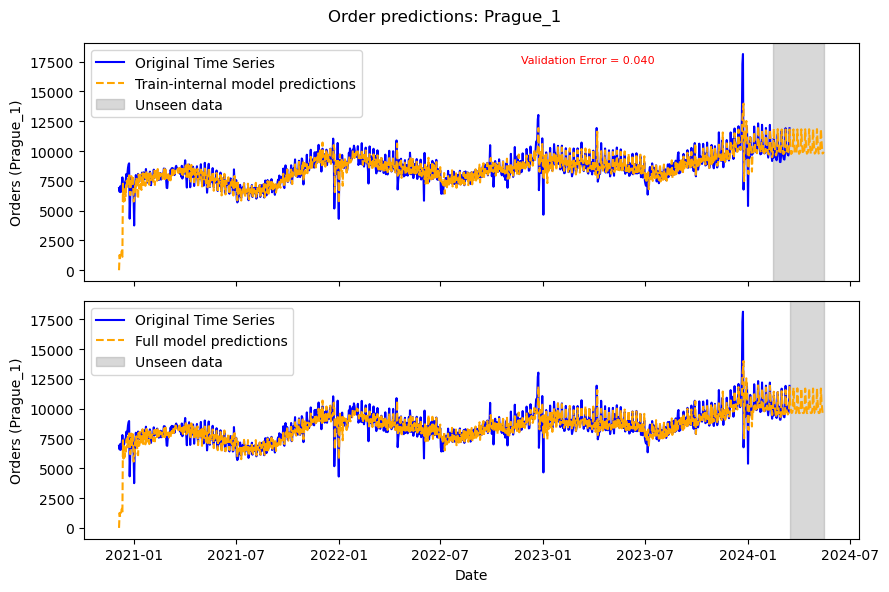

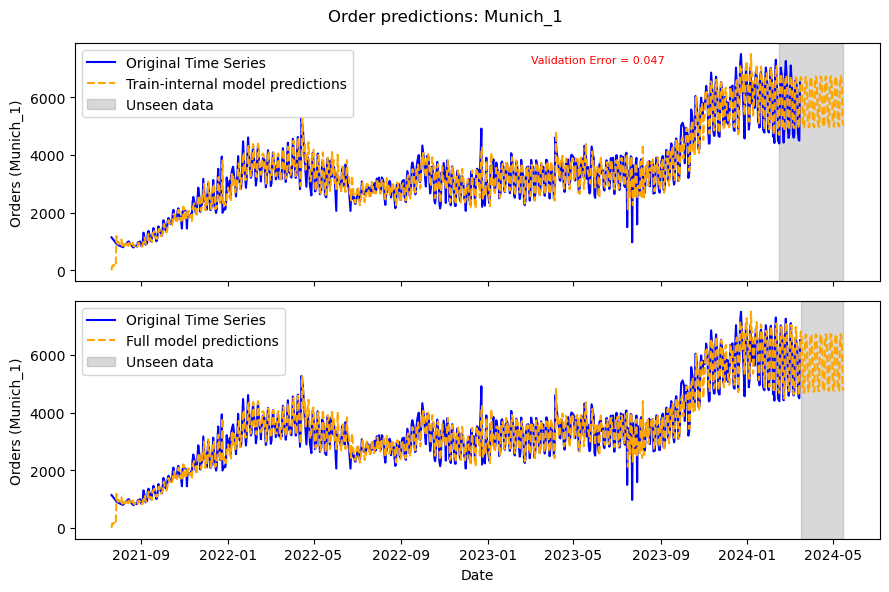

In [ ]:
plot_order_predictions(data, all_predictions, "seasonal_arima_seasdiff", warehouses=("Prague_1", "Munich_1"))

## 4.5 Auto ARIMA

## 4.X Prophet

# 5. Global modelling

# 6. Deep learning

# 7. Approach comparison

# 8. Conclusions

## 8.1 Limitations and next steps

 * Precipitation, snow and user activity are available for the training but not the test data. For our global model, we forecasted these as an initial step, then fed these predictions into the orders forecaster. In this project we were limited to the data we had available, but in reality it would be better to use the "real" weather forecast, as the models this is based on are more complex and incorporate more information.
 * Other solutions found an increase in predictive performance when filling in holidays using external information (e.g., https://www.kaggle.com/code/darkswordmg/rohlik-2024-2nd-place-solution-single-lgbm#3.-Data-processing). 
 * The feature engineering carried out in this project were primarily designed for use by the non-linear methods (i.e., boosted trees). We might have been able to improve the ARIMA models further, for example by providing simpler exogenous variables.

TODO:

* Make function for plotting predictions
* Finish exponential modelling
* Apply both standard ARIMA and auto ARIMA
* Apply prophet
* Use XGBoost/LGBM with appropriate transformers (tfidfvectorizer, LabelEncoder, pipeline, ColumnTransformer, TransformedTargetRegressor)
* Apply an LSTM approach